In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

### Functions declaration

In [2]:
def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
    
    return mean_results


## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

import numpy as np
import xarray as xr
from scipy.stats import t

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.DataArrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, standard error on regression,
    and R-squared between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    # 1. Ensure that the data are properly aligned to each other. 
    x, y = xr.align(x, y)
    
    # 2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        x = x.shift(time=-lagx).dropna(dim='time')
        x, y = xr.align(x, y)

    if lagy != 0:
        y = y.shift(time=-lagy).dropna(dim='time')
        x, y = xr.align(x, y)
 
    # 3. Compute data length, mean and standard deviation along time axis for further use
    n = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    # 4. Compute covariance along time axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / n
    
    # 5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    # 6. Compute regression slope and intercept
    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope
    y_pred = intercept + slope * x
    res = y - y_pred

    # 7. Compute P-value and standard error
    # Compute t-statistics
    tstats = cor * np.sqrt(n-2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats
    
    pval = t.sf(tstats, n-2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # 8. Compute R-squared
    sst = np.sum((y - ymean) ** 2, axis=0)
    ssr = np.sum(res ** 2, axis=0)
    r_squared = 1 - ssr / sst

    r_squared = xr.DataArray(r_squared, dims=cor.dims, coords=cor.coords)

    return slope, cov, intercept, pval, stderr, r_squared, y_pred


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [4]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/figures'

# -- Create directories
checkDir(out_path)

## Import data

### Open 1pctCO2-bgc data

NEP

In [5]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-bgc'
var_name = 'nep'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_bgc_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_bgc_nep.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_bgc_nep):
    ds_bgc_nep[i] = ds_bgc_nep[i].isel(time = slice(0,1680))
    ds_bgc_nep[i] = ds_bgc_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_bgc_nep[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_bgc_nep[i] = ds_bgc_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_bgc_nep[i] = ds_bgc_nep[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_bgc_nep[i] = ds_bgc_nep[i].where(ds_bgc_nep[i] != -3.7270379e-07)


In [6]:
for i, item in enumerate(ds_bgc_nep):
    if item.esm in {"BCC-CSM2-MR","E3SM-1-1-ECA","TaiESM1","NorESM2-MM"}:
        del ds_bgc_nep[i]
    print(ds_bgc_nep[i].esm)

ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


NBP

In [7]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-bgc'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_bgc_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_bgc_nbp.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_bgc_nbp):
    ds_bgc_nbp[i] = ds_bgc_nbp[i].isel(time = slice(0,1680))
    ds_bgc_nbp[i] = ds_bgc_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_bgc_nbp[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_bgc_nbp[i] = ds_bgc_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_bgc_nbp[i] = ds_bgc_nbp[i].resample(time="Y", label='right').mean()


# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_bgc_nbp[i] = ds_bgc_nbp[i].where(ds_bgc_nbp[i] != -3.7270379e-07)


In [8]:
for i, item in enumerate(ds_bgc_nbp):
    if item.esm in {"BCC-CSM2-MR","E3SM-1-1-ECA","TaiESM1","NorESM2-MM"}:
        del ds_bgc_nbp[i]
    print(ds_bgc_nbp[i].esm)

ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


#### Open CO2

In [9]:
data = np.loadtxt('F:/Data/analysis/1pctCO2-bgc/co2_1pctCO2-bgc.txt')

# Extract lon, lat, and data values from the loaded data
time = data[:140, 0]
values = data[:140, 1]

ds_co2 = []
for i,item in enumerate(ds_bgc_nep):

    lons = item.lon.values
    lats = item.lat.values

    # Create coordinate arrays
    time_coords = pd.date_range(start = "1850", periods=time.shape[0], freq = "Y") # xr.DataArray(time, dims='time', name='time')
    lon_coords = xr.DataArray(lons, dims='lon', name='lon')
    lat_coords = xr.DataArray(lats, dims='lat', name='lat')

    # Create a sample data array with a constant value for all grid cells
    constant_value = 10  # Replace with your desired constant value
    data_values = np.full((len(time), len(lats), len(lons)), constant_value)

    # Create the DataArray
    co2 = xr.DataArray(data_values, 
                            coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
                            dims=['time', 'lat', 'lon'], 
                            name='ppm').astype("float64")

    for i,item in enumerate(time):
        co2[i] = values[i]
    ds_co2.append(co2)

ds_co2 = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_co2]

### open 1pctCO2-rad data

In [10]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'nep'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rad_nep.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad_nep):
    ds_rad_nep[i] = ds_rad_nep[i].isel(time = slice(0,1680))
    ds_rad_nep[i] = ds_rad_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad_nep[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rad_nep[i] = ds_rad_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad_nep[i] = ds_rad_nep[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad_nep[i] = ds_rad_nep[i].where(ds_rad_nep[i] != -3.7270379e-07)


NBP

In [11]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rad_nbp.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad_nbp):
    ds_rad_nbp[i] = ds_rad_nbp[i].isel(time = slice(0,1680))
    ds_rad_nbp[i] = ds_rad_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad_nbp[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rad_nbp[i] = ds_rad_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad_nbp[i] = ds_rad_nbp[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad_nbp[i] = ds_rad_nbp[i].where(ds_rad_nbp[i] != -3.7270379e-07)


Temperature

In [12]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'tas'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rad_tas.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad_tas):
    ds_rad_tas[i] = ds_rad_tas[i].isel(time = slice(0,1680))
    ds_rad_tas[i] = ds_rad_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad_tas[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rad_tas[i] = ds_rad_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad_tas[i] = ds_rad_tas[i].resample(time="Y", label='right').mean()
    if "height" in ds_rad_tas[i].coords:
        ds_rad_tas[i] = ds_rad_tas[i].drop_vars("height")
        
# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad_tas[i] = ds_rad_tas[i].where(ds_rad_tas[i] != -3.7270379e-07)


Precipitation

In [13]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'pr'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rad_pr.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad_pr):
    ds_rad_pr[i] = ds_rad_pr[i].isel(time = slice(0,1680))
    ds_rad_pr[i] = ds_rad_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad_pr[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rad_pr[i] = ds_rad_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad_pr[i] = ds_rad_pr[i].resample(time="Y", label='right').sum()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad_pr[i] = ds_rad_pr[i].where(ds_rad_pr[i] != -3.7270379e-07)


Soil Moisture

In [14]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rad_mrso.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad_mrso):
    ds_rad_mrso[i] = ds_rad_mrso[i].isel(time = slice(0,1680))
    ds_rad_mrso[i] = ds_rad_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad_mrso[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rad_mrso[i] = ds_rad_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad_mrso[i] = ds_rad_mrso[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad_mrso[i] = ds_rad_mrso[i].where(ds_rad_mrso[i] != -3.7270379e-07)


Shortwave Incoming Radiation

In [15]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rad_rsds.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad_rsds):
    ds_rad_rsds[i] = ds_rad_rsds[i].isel(time = slice(0,1680))
    ds_rad_rsds[i] = ds_rad_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad_rsds[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rad_rsds[i] = ds_rad_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad_rsds[i] = ds_rad_rsds[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad_rsds[i] = ds_rad_rsds[i].where(ds_rad_rsds[i] != -3.7270379e-07)


Relative humidity

In [16]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'hurs'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad_hurs = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rad_hurs.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad_hurs):
    ds_rad_hurs[i] = ds_rad_hurs[i].isel(time = slice(0,1680))
    ds_rad_hurs[i] = ds_rad_hurs[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad_hurs[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rad_hurs[i] = ds_rad_hurs[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad_hurs[i] = ds_rad_hurs[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad_hurs[i] = ds_rad_hurs[i].where(ds_rad_hurs[i] != -3.7270379e-07)


#### Calculate VPD

In [17]:
import math

def calculate_vpd(rh, tas, unit):
    """
    Input: Relative Humidity and Air Temperature 
    Output: Vapour Pressure Deficit (VPD), in kPa
    
    Parameters:
    rh : Relative Humidity in %
    tas : Air temperature in Kelvin or Celsius
    unit : 'Kelvin' or 'Celsius'
    """
    
    # Convert temperature to Celsius if given in Kelvin
    if unit == "Kelvin":
        tas_celsius = tas - 273.15
    elif unit == "Celsius":
        tas_celsius = tas
    else:
        raise ValueError("Insert correct Unit of Measure for Temperature: 'Kelvin' or 'Celsius'")
    
    # Calculate Saturation Vapour Pressure (SVP) in kPa
    svp = 0.61078 * np.exp((17.27 * tas_celsius) / (tas_celsius + 237.3))
    # Calculate Vapour Pressure Deficit (VPD) in kPa
    vpd = svp * (1 - rh / 100)
    vpd = vpd.assign_attrs(unit = "kPa")
    vpd = vpd.assign_attrs(esm = tas.esm)

    return vpd

In [18]:
ds_rad_vpd = []
for i, item in enumerate(ds_rad_hurs):
    content = calculate_vpd(ds_rad_hurs[i], ds_rad_tas[i], "Celsius")
    ds_rad_vpd.append(content)

In [19]:
del ds_rad_hurs

#### Correct lon lat values

In [20]:
# Correct the number of longitude points
ds_rad_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad_mrso, ds_rad_nbp)]
ds_rad_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad_tas, ds_rad_nbp)]
ds_rad_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad_rsds, ds_rad_nbp)]
ds_rad_pr = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad_pr, ds_rad_nbp)]
ds_rad_vpd = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad_vpd, ds_rad_nbp)]
ds_rad_nbp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad_nbp, ds_rad_nbp)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_rad_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad_pr,ds_rad_nbp)]
ds_rad_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad_tas,ds_rad_nbp)]
ds_rad_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad_mrso,ds_rad_nbp)]
ds_rad_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad_rsds,ds_rad_nbp)]
ds_rad_vpd = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad_vpd,ds_rad_nbp)]
ds_rad_nbp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad_nbp,ds_rad_nbp)]

In [21]:
esm = list()
for item in ds_rad_nbp:
    esm.append(item.esm)

### Open ssp585-bgc data

In [22]:
models = ["ACCESS-ESM1-5", "CNRM-ESM2-1", "CanESM5", "MIROC-ES2L", "MRI-ESM2-0", "UKESM1-0-LL"] #, "NorESM2-LM"

In [23]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-bgc'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_bgc585_nbp = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_bgc585_nbp.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_bgc585_nbp):
    ds_bgc585_nbp[i] = ds_bgc585_nbp[i].isel(time = slice(0,1032))
    ds_bgc585_nbp[i] = ds_bgc585_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_bgc585_nbp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_bgc585_nbp[i] = ds_bgc585_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_bgc585_nbp[i] = ds_bgc585_nbp[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_bgc585_nbp[i] = ds_bgc585_nbp[i].where(ds_bgc585_nbp[i] != -3.7270379e-07)


#### Open CO2

In [24]:
data = np.loadtxt('F:/Data/analysis/ssp585/co2_ssp585.txt')

# Extract lon, lat, and data values from the loaded data
time = data[:86, 0]
values = data[:86, 1]

ds_ssp_co2 = []
for m, model in enumerate(models):
    
    lons = ds_bgc585_nbp[m].lon.values
    lats = ds_bgc585_nbp[m].lat.values

    # Create coordinate arrays
    time_coords = pd.date_range(start = "2015", periods=time.shape[0], freq = "Y") # xr.DataArray(time, dims='time', name='time')
    lon_coords = xr.DataArray(lons, dims='lon', name='lon')
    lat_coords = xr.DataArray(lats, dims='lat', name='lat')

    # Create a sample data array with a constant value for all grid cells
    constant_value = 10  # Replace with your desired constant value
    data_values = np.full((len(time), len(lats), len(lons)), constant_value)

    # Create the DataArray
    co2 = xr.DataArray(data_values, 
                            coords={'time': time_coords, 'lat': lats, 'lon': lons}, 
                            dims=['time', 'lat', 'lon'],
                            name='ppm').astype("float64")

    for i,item in enumerate(time):
        co2[i] = values[i]
    ds_ssp_co2.append(co2)

ds_ssp_co2 = [a.sel(lat=slice(-30,30), lon= slice(260,340)) for a in ds_ssp_co2]


### Open ssp585-rad data

NBP

In [25]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-rad'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad585_nbp = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_rad585_nbp.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad585_nbp):
    ds_rad585_nbp[i] = ds_rad585_nbp[i].isel(time = slice(0,1032))
    ds_rad585_nbp[i] = ds_rad585_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad585_nbp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_rad585_nbp[i] = ds_rad585_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad585_nbp[i] = ds_rad585_nbp[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad585_nbp[i] = ds_rad585_nbp[i].where(ds_rad585_nbp[i] != -3.7270379e-07)


Precipitation

In [26]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-rad'
var_name = 'pr'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad585_pr = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_rad585_pr.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad585_pr):
    ds_rad585_pr[i] = ds_rad585_pr[i].isel(time = slice(0,1032))
    ds_rad585_pr[i] = ds_rad585_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad585_pr[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_rad585_pr[i] = ds_rad585_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad585_pr[i] = ds_rad585_pr[i].resample(time="Y", label='right').sum()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad585_pr[i] = ds_rad585_pr[i].where(ds_rad585_pr[i] != -3.7270379e-07)


Temperature

In [27]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-rad'
var_name = 'tas'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad585_tas = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_rad585_tas.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad585_tas):
    ds_rad585_tas[i] = ds_rad585_tas[i].isel(time = slice(0,1032))
    ds_rad585_tas[i] = ds_rad585_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad585_tas[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_rad585_tas[i] = ds_rad585_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad585_tas[i] = ds_rad585_tas[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad585_tas[i] = ds_rad585_tas[i].where(ds_rad585_tas[i] != -3.7270379e-07)


Precipitation

In [28]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-rad'
var_name = 'pr'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad585_pr = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_rad585_pr.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad585_pr):
    ds_rad585_pr[i] = ds_rad585_pr[i].isel(time = slice(0,1032))
    ds_rad585_pr[i] = ds_rad585_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad585_pr[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_rad585_pr[i] = ds_rad585_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad585_pr[i] = ds_rad585_pr[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad585_pr[i] = ds_rad585_pr[i].where(ds_rad585_pr[i] != -3.7270379e-07)


Soil Moisture

In [29]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-rad'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad585_mrso = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_rad585_mrso.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad585_mrso):
    ds_rad585_mrso[i] = ds_rad585_mrso[i].isel(time = slice(0,1032))
    ds_rad585_mrso[i] = ds_rad585_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad585_mrso[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_rad585_mrso[i] = ds_rad585_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad585_mrso[i] = ds_rad585_mrso[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad585_mrso[i] = ds_rad585_mrso[i].where(ds_rad585_mrso[i] != -3.7270379e-07)


Shortwave Incoming Radiation

In [30]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-rad'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad585_rsds = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_rad585_rsds.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad585_rsds):
    ds_rad585_rsds[i] = ds_rad585_rsds[i].isel(time = slice(0,1032))
    ds_rad585_rsds[i] = ds_rad585_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad585_rsds[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_rad585_rsds[i] = ds_rad585_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad585_rsds[i] = ds_rad585_rsds[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad585_rsds[i] = ds_rad585_rsds[i].where(ds_rad585_rsds[i] != -3.7270379e-07)


Relative humidity

In [31]:
data_path = 'F:/Data/analysis'

scenario = 'ssp585-rad'
var_name = 'hurs'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for model in models:
        filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rad585_hurs = []
for model in models:
    filepath = glob.glob(os.path.join(data_path+'/'+scenario+'/'+ var_name + "_" + model + "_" + scenario + '*.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"], engine = "netcdf4")          #, chunks = {"time" : 720}
    ds_rad585_hurs.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rad585_hurs):
    ds_rad585_hurs[i] = ds_rad585_hurs[i].isel(time = slice(0,1032))
    ds_rad585_hurs[i] = ds_rad585_hurs[i].assign_attrs(esm=files_list[i].source_id)
    ds_rad585_hurs[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_rad585_hurs[i] = ds_rad585_hurs[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rad585_hurs[i] = ds_rad585_hurs[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rad585_hurs[i] = ds_rad585_hurs[i].where(ds_rad585_hurs[i] != -3.7270379e-07)


#### Calculate VPD

In [32]:
ds_rad585_vpd = []
for i, item in enumerate(ds_rad585_hurs):
    content = calculate_vpd(ds_rad585_hurs[i], ds_rad585_tas[i], "Celsius")
    ds_rad585_vpd.append(content)

#### Correct lon lat values

In [33]:
# Correct the number of longitude points
ds_rad585_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad585_mrso, ds_rad585_nbp)]
ds_rad585_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad585_tas, ds_rad585_nbp)]
ds_rad585_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad585_rsds, ds_rad585_nbp)]
ds_rad585_pr = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad585_pr, ds_rad585_nbp)]
ds_rad585_vpd = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad585_vpd, ds_rad585_nbp)]
# ds_rad585_nbp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rad585_nbp, ds_rad585_nbp)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_rad585_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad585_pr,ds_rad585_nbp)]
ds_rad585_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad585_tas,ds_rad585_nbp)]
ds_rad585_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad585_mrso,ds_rad585_nbp)]
ds_rad585_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad585_rsds,ds_rad585_nbp)]
ds_rad585_vpd = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad585_vpd,ds_rad585_nbp)]
# ds_rad585_nbp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rad585_nbp,ds_rad585_nbp)]


### Open ssp585 data

NEP

In [34]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'nep'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_nep.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_nep):
    ds_ssp_nep[i] = ds_ssp_nep[i].isel(time = slice(0,1032))
    ds_ssp_nep[i] = ds_ssp_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_nep[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_nep[i] = ds_ssp_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_nep[i] = ds_ssp_nep[i].resample(time="Y", label='right').mean()

NBP

In [35]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_nbp.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_nbp):
    ds_ssp_nbp[i] = ds_ssp_nbp[i].isel(time = slice(0,1032))
    ds_ssp_nbp[i] = ds_ssp_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_nbp[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_nbp[i] = ds_ssp_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_nbp[i] = ds_ssp_nbp[i].resample(time="Y", label='right').mean()

Temperature

In [36]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'tas'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_tas.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_tas):
    ds_ssp_tas[i] = ds_ssp_tas[i].isel(time = slice(0,1032))
    ds_ssp_tas[i] = ds_ssp_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_tas[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_tas[i] = ds_ssp_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_tas[i] = ds_ssp_tas[i].resample(time="Y", label='right').mean()
    if "height" in ds_ssp_tas[i].coords:
        ds_ssp_tas[i] = ds_ssp_tas[i].drop_vars("height")

Precipitation

In [37]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'pr'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_pr.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_pr):
    ds_ssp_pr[i] = ds_ssp_pr[i].isel(time = slice(0,1032))
    ds_ssp_pr[i] = ds_ssp_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_pr[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_pr[i] = ds_ssp_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_pr[i] = ds_ssp_pr[i].resample(time="Y", label='right').sum()


Soil Moisture

In [38]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_mrso.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_mrso):
    ds_ssp_mrso[i] = ds_ssp_mrso[i].isel(time = slice(0,1032))
    ds_ssp_mrso[i] = ds_ssp_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_mrso[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_mrso[i] = ds_ssp_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_mrso[i] = ds_ssp_mrso[i].resample(time="Y", label='right').mean()


SWin

In [39]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_rsds.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_rsds):
    ds_ssp_rsds[i] = ds_ssp_rsds[i].isel(time = slice(0,1032))
    ds_ssp_rsds[i] = ds_ssp_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_rsds[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_rsds[i] = ds_ssp_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_rsds[i] = ds_ssp_rsds[i].resample(time="Y", label='right').mean()


Relative humidity

In [40]:
data_path = 'F:/Data/analysis/'              

scenario = 'ssp585'
var_name = 'hurs'
files = var_name + '_*_' + scenario + '_*' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUTES

ds_ssp_hurs = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_ssp_hurs.append(content)

# Retain from year 2015 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_ssp_hurs):
    ds_ssp_hurs[i] = ds_ssp_hurs[i].isel(time = slice(0,1032))
    ds_ssp_hurs[i] = ds_ssp_hurs[i].assign_attrs(esm=files_list[i].source_id)
    ds_ssp_hurs[i]['time'] = pd.date_range(start = "2015", periods=1032, freq = "M")
    ds_ssp_hurs[i] = ds_ssp_hurs[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_ssp_hurs[i] = ds_ssp_hurs[i].resample(time="Y", label='right').mean()
    if "height" in ds_ssp_hurs[i].coords:
        ds_ssp_hurs[i] = ds_ssp_hurs[i].drop_vars("height")


Correct UKESM lon numbers

In [41]:
ds_ssp_nep[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_nep[37:40]]
ds_ssp_nbp[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_nbp[37:40]]
ds_ssp_mrso[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_mrso[37:40]]
ds_ssp_tas[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_tas[37:40]]
ds_ssp_rsds[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_rsds[37:40]]
ds_ssp_hurs[37:40] = [a.isel(lon = slice(0,191)) for a in ds_ssp_hurs[37:40]]

#### Calculate VPD

In [42]:
import math

def calculate_vpd(rh, tas, unit):
    """
    Input: Relative Humidity and Air Temperature 
    Output: Vapour Pressure Deficit (VPD), in kPa
    
    Parameters:
    rh : Relative Humidity in %
    tas : Air temperature in Kelvin or Celsius
    unit : 'Kelvin' or 'Celsius'
    """
    
    # Convert temperature to Celsius if given in Kelvin
    if unit == "Kelvin":
        tas_celsius = tas - 273.15
    elif unit == "Celsius":
        tas_celsius = tas
    else:
        raise ValueError("Insert correct Unit of Measure for Temperature: 'Kelvin' or 'Celsius'")
    
    # Calculate Saturation Vapour Pressure (SVP) in kPa
    svp = 0.61078 * np.exp((17.27 * tas_celsius) / (tas_celsius + 237.3))
    # Calculate Vapour Pressure Deficit (VPD) in kPa
    vpd = svp * (1 - rh / 100)
    vpd = vpd.assign_attrs(unit = "kPa")
    vpd = vpd.assign_attrs(esm = tas.esm)

    return vpd

In [43]:
ds_ssp_vpd = []
for i, item in enumerate(ds_ssp_hurs):
    content1 = calculate_vpd(ds_ssp_hurs[i], ds_ssp_tas[i], "Celsius")

    ds_ssp_vpd.append(content1)

In [44]:
del ds_ssp_hurs

#### Correct for lon lat values

In [45]:
# Correct the number of longitude points
ds_ssp_nep = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nep, ds_ssp_nbp)]
ds_ssp_vpd = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_vpd, ds_ssp_nbp)]
ds_ssp_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_rsds, ds_ssp_nbp)]
ds_ssp_nbp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_nbp, ds_ssp_nbp)]
ds_ssp_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_mrso, ds_ssp_nbp)]
ds_ssp_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_tas, ds_ssp_nbp)]
ds_ssp_pr = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_ssp_pr, ds_ssp_nbp)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_ssp_nep = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_nep,ds_ssp_nbp)]
ds_ssp_vpd = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_vpd,ds_ssp_nbp)]
ds_ssp_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_rsds,ds_ssp_nbp)]
ds_ssp_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_tas,ds_ssp_nbp)]
ds_ssp_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_mrso,ds_ssp_nbp)]
ds_ssp_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_ssp_pr,ds_ssp_nbp)]


#### Average ESM simulations 

In [46]:
ds_ssp_nep = xr_mean_list(ds_ssp_nep)
ds_ssp_nbp = xr_mean_list(ds_ssp_nbp)
ds_ssp_mrso = xr_mean_list(ds_ssp_mrso)
ds_ssp_tas = xr_mean_list(ds_ssp_tas)
ds_ssp_rsds = xr_mean_list(ds_ssp_rsds)
ds_ssp_vpd = xr_mean_list(ds_ssp_vpd)
ds_ssp_pr = xr_mean_list(ds_ssp_pr)

In [47]:
esm = list(ds_ssp_nbp.keys())
print(esm)

['ACCESS-ESM1-5', 'CESM2', 'CMCC-ESM2', 'CNRM-ESM2-1', 'CanESM5', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'NorESM2-LM', 'UKESM1-0-LL']


## AMZ trends

In [48]:
# ds_nep_mean_amz = zonal_stat(ds_nep_mean, geodf).sel(region = 1)
ds_co2_amz = zonal_stat(ds_co2[0], geodf).sel(region = 1)
df_bgc_amz = ds_co2_amz.to_dataframe().drop(columns = ["region"])
for m, mm in enumerate(esm):
    
    content = zonal_stat(ds_bgc_nep[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nep":"nep " + mm})
    content1 = zonal_stat(ds_bgc_nbp[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + mm})
    df_bgc_amz = pd.concat([df_bgc_amz, content, content1], axis = 1)


ds_ssp_co2_amz = zonal_stat(ds_ssp_co2[0], geodf).sel(region = 1)
df_bgc585_amz = ds_ssp_co2_amz.to_dataframe().drop(columns = ["region"])
for m, mm in enumerate(models):
    
    # content = zonal_stat(ds_bgc585_nep[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nep":"nep " + mm})
    content1 = zonal_stat(ds_bgc585_nbp[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + mm})
    df_bgc585_amz = pd.concat([df_bgc585_amz, content1], axis = 1)


In [49]:
# ds_nep_mean_amz = zonal_stat(ds_nep_mean, geodf).sel(region = 1)
ds_co2_amz = zonal_stat(ds_co2[0], geodf).sel(region = 1)

df_rad_amz = ds_co2_amz.to_dataframe().drop(columns = ["region"])
for m, mm in enumerate(esm):
    
    content = zonal_stat(ds_rad_nep[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nep":"nep " + mm})
    content1 = zonal_stat(ds_rad_nbp[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + mm})
    content2 = zonal_stat(ds_rad_tas[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"tas":"tas " + mm})
    content3 = zonal_stat(ds_rad_mrso[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"mrso":"mrso " + mm})
    content4 = zonal_stat(ds_rad_rsds[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"rsds":"rsds " + mm})
    content5 = zonal_stat(ds_rad_vpd[m], geodf).sel(region = 1).to_dataframe(name = "vpd").drop(columns = ["region"]).rename(columns = {"vpd":"vpd " + mm})
    content6 = zonal_stat(ds_rad_pr[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"pr":"pr " + mm})

    df_rad_amz = pd.concat([df_rad_amz, content, content1, content2, content3, content4, content5, content6], axis = 1)
df_rad_amz = df_rad_amz.drop(columns = "height")

ds_ssp_co2_amz = zonal_stat(ds_ssp_co2[0], geodf).sel(region = 1)

df_rad585_amz = ds_ssp_co2_amz.to_dataframe().drop(columns = ["region"])
for m, mm in enumerate(models):
    
    content1 = zonal_stat(ds_rad585_nbp[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + mm})
    content2 = zonal_stat(ds_rad585_tas[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"tas":"tas " + mm})
    content3 = zonal_stat(ds_rad585_mrso[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"mrso":"mrso " + mm})
    content4 = zonal_stat(ds_rad585_rsds[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"rsds":"rsds " + mm})
    content5 = zonal_stat(ds_rad585_vpd[m], geodf).sel(region = 1).to_dataframe(name = "vpd").drop(columns = ["region"]).rename(columns = {"vpd":"vpd " + mm})
    content6 = zonal_stat(ds_rad585_pr[m], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"pr":"pr " + mm})

    df_rad585_amz = pd.concat([df_rad585_amz, content1, content2, content3, content4, content5, content6], axis = 1)
df_rad585_amz = df_rad585_amz.drop(columns = "height")


In [50]:
# ds_nep_mean_amz = zonal_stat(ds_nep_mean, geodf).sel(region = 1)
ds_ssp_co2_amz = zonal_stat(ds_ssp_co2[0], geodf).sel(region = 1)

df_ssp_amz = ds_ssp_co2_amz.to_dataframe().drop(columns = ["region"])
for m, mm in enumerate(esm):
    
    content = zonal_stat(ds_ssp_nep[mm], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nep":"nep " + mm})
    content1 = zonal_stat(ds_ssp_nbp[mm], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + mm})
    content2 = zonal_stat(ds_ssp_tas[mm], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"tas":"tas " + mm})
    content3 = zonal_stat(ds_ssp_mrso[mm], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"mrso":"mrso " + mm})
    content4 = zonal_stat(ds_ssp_rsds[mm], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"rsds":"rsds " + mm})
    content5 = zonal_stat(ds_ssp_vpd[mm], geodf).sel(region = 1).to_dataframe(name = "vpd").drop(columns = ["region"]).rename(columns = {"vpd":"vpd " + mm})
    content6 = zonal_stat(ds_ssp_pr[mm], geodf).sel(region = 1).to_dataframe().drop(columns = ["region"]).rename(columns = {"pr":"pr " + mm})

    df_ssp_amz = pd.concat([df_ssp_amz, content, content1, content2, content3, content4, content5, content6], axis = 1)

# 10 years running mean
# for k in ds_ssp_nep.keys():
#         # rr = files_list[k].parent_variant_label
#         # df_ssp_amz_rad["nep " + k] = df_ssp_amz_rad["nep " + k].rolling(10, center=True).mean()
#         # df_ssp_amz_rad["nbp " + k] = df_ssp_amz_rad["nbp " + k].rolling(10, center=True).mean()
# df_ssp_amz_rad = df_ssp_amz_rad.dropna()

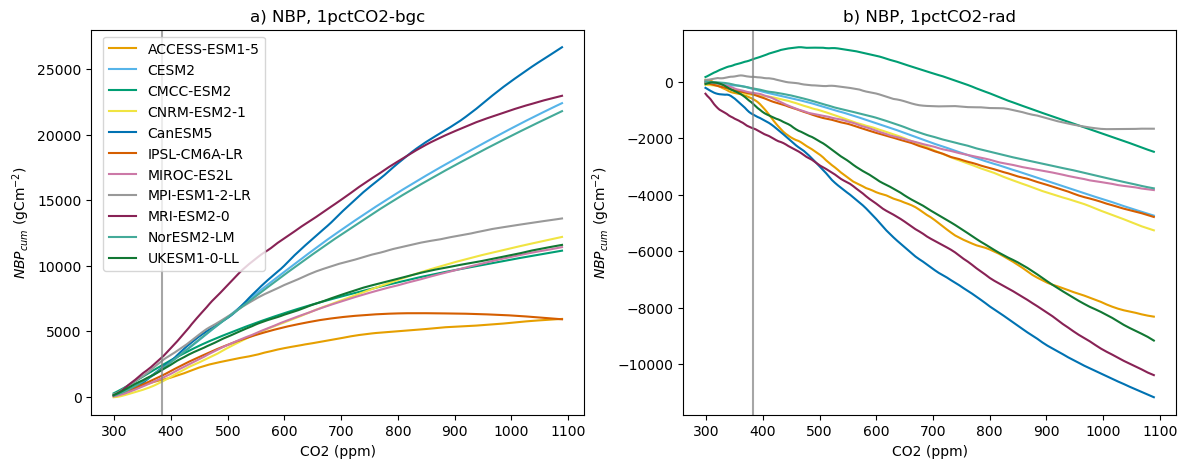

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig = plt.figure(figsize=(14, 5))

colorblind_12 = [
   "#E69F00", "#56B4E9", "#009E73", "#F0E442",
    "#0072B2", "#D55E00", "#CC79A7", "#999999",
    "#882255", "#44AA99", "#117733", "#DDCC77"
] 

colors = {model: colorblind_12[i] for i, model in enumerate(esm)}

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
for m, mm in enumerate(esm):
    ax0.plot(df_bgc_amz["ppm"], df_bgc_amz['nbp ' + mm].cumsum().rolling(10, center=True).mean(), label=mm, color = colors[mm])  # Line plot for NEP
# Set labels and title
ax0.set_xlabel("CO2 (ppm)")
ax0.set_ylabel("$NBP_{cum}$ (gCm$^{-2}$)")
# ax0.set_ylim(-80, 1400)
# Highlight a specific CO2 value with a vertical line
ax0.axvline(df_bgc_amz.iloc[30]["ppm"], color="grey", alpha=0.7)
# Add legend and title
ax0.legend(esm, loc='upper left', bbox_to_anchor = [0.01, 1])
ax0.set_title("a) NBP, 1pctCO2-bgc")

# Second plot for NBP
ax1 = fig.add_subplot(122)
for m, mm in enumerate(esm):
    ax1.plot(df_rad_amz["ppm"], df_rad_amz['nbp ' + mm].cumsum().rolling(10, center=True).mean(), label=mm, color = colors[mm])  # Line plot for NBP
    
# Set labels and title
ax1.set_xlabel("CO2 (ppm)")
ax1.set_ylabel("$NBP_{cum}$ (gCm$^{-2}$)")
# ax1.set_ylim(-80, 400)
# Highlight a specific CO2 value with a vertical line
ax1.axvline(df_bgc_amz.iloc[30]["ppm"], color="grey", alpha=0.7)
# Add legend and title
ax1.set_title("b) NBP, 1pctCO2-rad")



plt.show()

title = "Figure_S6"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)


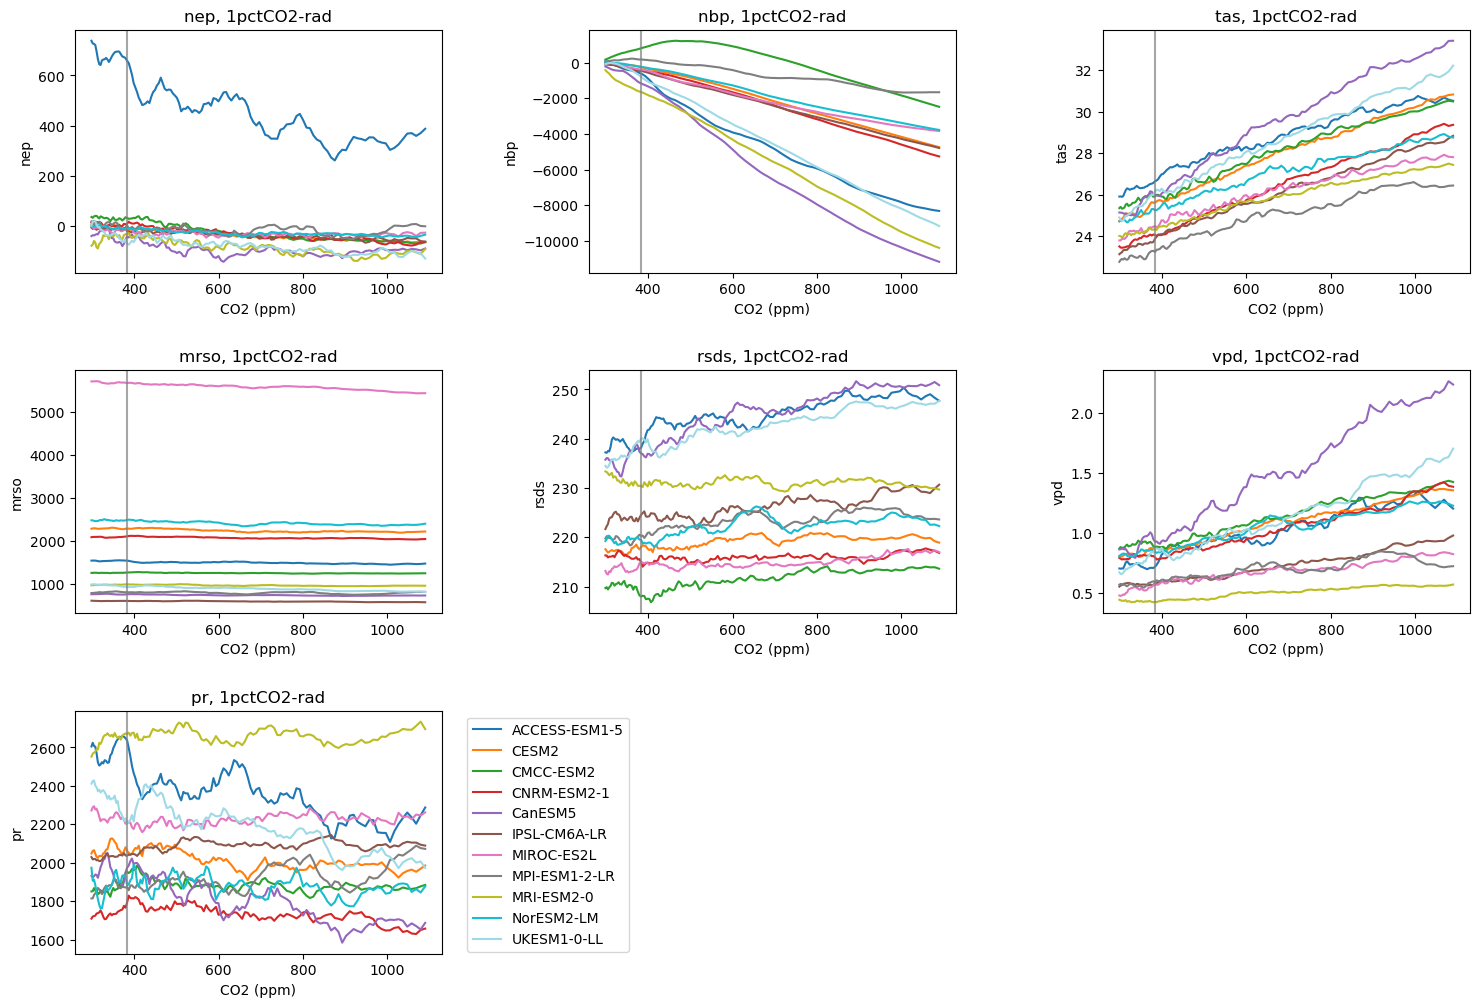

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3x3 grid
fig.subplots_adjust(hspace=0.4, wspace=0.4)       # Spacing between plots

# Define colors for each model
cmap = plt.cm.get_cmap('tab20', len(esm))
colors = [cmap(i) for i in range(len(esm))]

# List of variables (columns) to plot, assuming df_rad_amz has the required columns
variables = ["nep", "nbp", "tas", "mrso", "rsds", "vpd", "pr"]

# Plot each variable in its own subplot
for i, var in enumerate(variables):
    ax = axes.flatten()[i]   # Flatten the 3x3 grid to index subplots linearly
    for m, mm in enumerate(esm):
        if var == "nbp":
            ax.plot(df_rad_amz["ppm"], df_rad_amz[f'{var} ' + mm].cumsum().rolling(10, center=True).mean(), label=mm, color=colors[m])
        else:
            ax.plot(df_rad_amz["ppm"], df_rad_amz[f'{var} ' + mm].rolling(10, center=True).mean(), label=mm, color=colors[m])

    # Set labels and title
    ax.set_xlabel("CO2 (ppm)")
    ax.set_ylabel(f"{var}")
    # ax.set_ylim(-80, 1400)
    ax.axvline(df_rad_amz.iloc[30]["ppm"], color="grey", alpha=0.7)
    ax.set_title(f"{var}, 1pctCO2-rad")

# Remove any remaining empty subplots (last two in the 3x3 grid)
for j in range(i + 1, 9):
    fig.delaxes(axes.flatten()[j])

# Add legend on the last non-empty plot
ax.legend(esm, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()


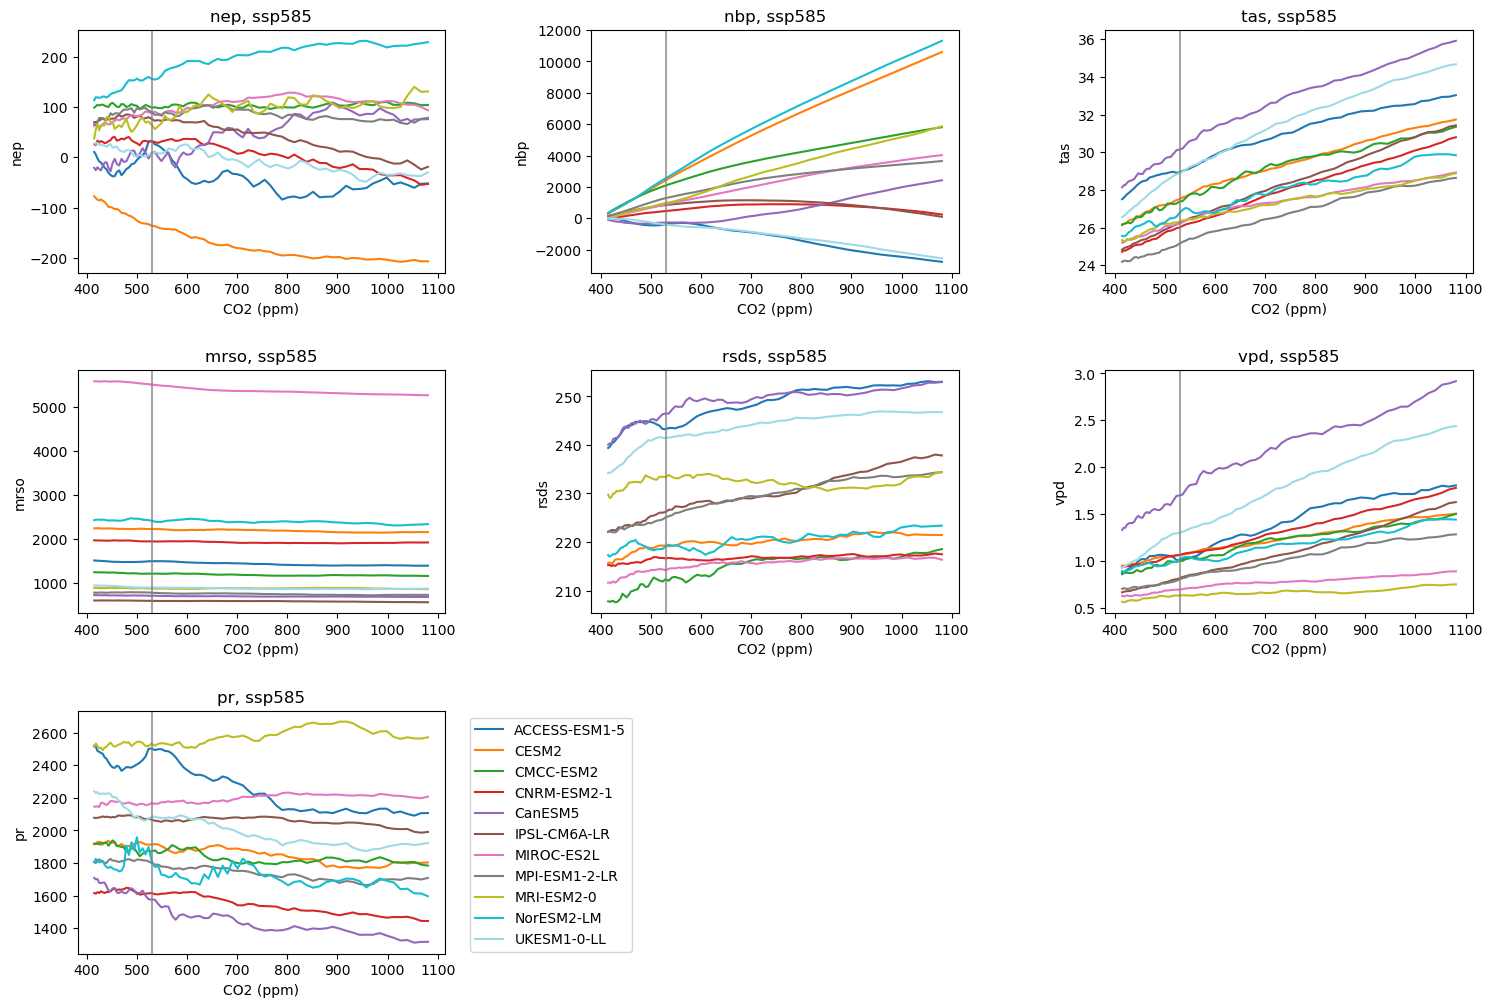

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, axes = plt.subplots(3, 3, figsize=(18, 12))  # 3x3 grid
fig.subplots_adjust(hspace=0.4, wspace=0.4)       # Spacing between plots

# Define colors for each model
cmap = plt.cm.get_cmap('tab20', len(esm))
colors = [cmap(i) for i in range(len(esm))]

# List of variables (columns) to plot, assuming df_ssp_amz has the required columns
variables = ["nep", "nbp", "tas", "mrso", "rsds", "vpd", "pr"]

# Plot each variable in its own subplot
for i, var in enumerate(variables):
    ax = axes.flatten()[i]   # Flatten the 3x3 grid to index subplots linearly
    for m, mm in enumerate(esm):
        if var == "nbp":
            ax.plot(df_ssp_amz["ppm"], df_ssp_amz[f'{var} ' + mm].cumsum().rolling(10, center=True).mean(), label=mm, color=colors[m])
        else:
            ax.plot(df_ssp_amz["ppm"], df_ssp_amz[f'{var} ' + mm].rolling(10, center=True).mean(), label=mm, color=colors[m])

    # Set labels and title
    ax.set_xlabel("CO2 (ppm)")
    ax.set_ylabel(f"{var}")
    # ax.set_ylim(-80, 1400)
    ax.axvline(df_ssp_amz.iloc[30]["ppm"], color="grey", alpha=0.7)
    ax.set_title(f"{var}, ssp585")

# Remove any remaining empty subplots (last two in the 3x3 grid)
for j in range(i + 1, 9):
    fig.delaxes(axes.flatten()[j])

# Add legend on the last non-empty plot
ax.legend(esm, loc='upper left', bbox_to_anchor=(1.05, 1))

plt.show()


# Part1: Long-term changes

## Long-term BETA


The relationship between NEP and CO2 is logarithimic, but if we consider the range of CO2 ppm of historical (280-400) and ssp585 (400-1135) separately, it is linear.\
For historical, the period is from 1850-01 to 1885-12 (36 yrs). \
For ssp585, the period is from 1886-01-01 to 1989-01-01 (104 yrs).

We calculate the long-term BETA carbon-concentration feeback from the 1pctCO2-bgc simulation as:

\begin{equation}
\Delta{NEP} = a_{0} + sCO_{2} * \Delta{ppm} + \epsilon
\end{equation}

We obtain $sCO_{2}$ as $gCm^{-2}yr^{-1}ppm^{-1}$. \
To obtain $gCm^{-2}ppm^{-1}$, we multiply $sCO_{2}$ by the number of years of the historical and ssp585 simulations. 

1pctCO2-bgc

In [53]:
beta_nep = []
beta_nbp = []

for m, mm in enumerate(esm):
    y = ds_bgc_nep[m].cumsum(dim = "time"); y = y[36:] - y[36]
    x = ds_co2[m][36:] - ds_co2[m][36]

    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    beta_nep.append({
            'slope': slope,
            'slope_std': slope*x[36:].std(dim = "time"),
            'intercept': intercept,
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    y = ds_bgc_nbp[m].cumsum(dim = "time"); y = y[36:] - y[36]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    beta_nbp.append({
            'slope': slope,
            'slope_std': slope*x[36:].std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

ssp585-bgc

In [54]:
beta585_nbp = []

for m, mm in enumerate(models):

    y = ds_bgc585_nbp[m].cumsum(dim = "time"); y = y - y[0]
    x = ds_ssp_co2[m] - ds_ssp_co2[m][0]

    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    beta585_nbp.append({
            'slope': slope,
            'slope_std': slope*x.std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

## Long-term GAMMA

We calculate the long-term GAMMA carbon-climate feeback from the 1pctCO2-rad simulation as:

\begin{equation}
\Delta{NEP} = a_{0} + sT * \Delta{T} + \epsilon
\end{equation}

\begin{equation}
\Delta{NEP} = a_{0} + smrso * \Delta{mrso} + \epsilon
\end{equation}

\begin{equation}
\Delta{NEP} = a_{0} + sSW_{in} * \Delta{SW_{in}} + \epsilon 
\end{equation}

We multiply $sT$, $sPr$, $sSW_{in}$, $smrso$ and $sVPD$ by the number of years of the historical and ssp585 simulations obtaining $gCm^{-2}unit^{-1}$ 

1pctCO2-rad

In [55]:
gamma_tas_nbp = []
gamma_mrso_nbp = []
gamma_rsds_nbp = []
gamma_vpd_nbp = []
gamma_pr_nbp = []

for m, mm in enumerate(esm):
    y = ds_rad_nbp[m].cumsum(dim = "time"); y = y[36:] - y[36]
    x = ds_rad_tas[m]; x = x[36:] - x[36]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma_tas_nbp.append({
            'slope': slope,
            'slope_std': slope*x[36:].std(dim = "time"),
            'intercept': intercept,
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    x = ds_rad_mrso[m]; x = x[36:] - x[36]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma_mrso_nbp.append({
            'slope': slope,
            'slope_std': slope*x[36:].std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    x = ds_rad_rsds[m]; x = x[36:] - x[36]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma_rsds_nbp.append({
            'slope': slope,
            'slope_std': slope*x[36:].std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    x = ds_rad_vpd[m]*10; x = x[36:] - x[36] # Multiply the VPD by 10, from kPa to hPa
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma_vpd_nbp.append({
            'slope': slope,
            'slope_std': slope*x[36:].std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })
    
    x = ds_rad_pr[m]; x = x[36:] - x[36]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma_pr_nbp.append({
            'slope': slope,
            'slope_std': slope*x[36:].std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

ssp585-rad

In [56]:
gamma585_tas_nbp = []
gamma585_mrso_nbp = []
gamma585_rsds_nbp = []
gamma585_vpd_nbp = []
gamma585_pr_nbp = []

for m, mm in enumerate(models):
    y = ds_rad585_nbp[m].cumsum(dim = "time"); y = y - y[0]
    x = ds_rad585_tas[m]; x = x - x[0]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma585_tas_nbp.append({
            'slope': slope,
            'slope_std': slope*x.std(dim = "time"),
            'intercept': intercept,
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    x = ds_rad585_mrso[m]; x = x - x[0]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma585_mrso_nbp.append({
            'slope': slope,
            'slope_std': slope*x.std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    x = ds_rad585_rsds[m]; x = x - x[0]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma585_rsds_nbp.append({
            'slope': slope,
            'slope_std': slope*x.std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

    x = ds_rad585_vpd[m]*10; x = x - x[0] # Multiply the VPD by 10, from kPa to hPa
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma585_vpd_nbp.append({
            'slope': slope,
            'slope_std': slope*x.std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })
    
    x = ds_rad585_pr[m]; x = x - x[0]
    slope,cov,intercept,pval,stderr,r2,ypred = lag_linregress_3D(x,y)
    gamma585_pr_nbp.append({
            'slope': slope,
            'slope_std': slope*x.std(dim = "time"),
            'intercept': intercept, 
            'p_value': pval,
            'std_err': stderr,
            'r_value': r2,
            'y_pred': ypred
        })

## Feedback maps

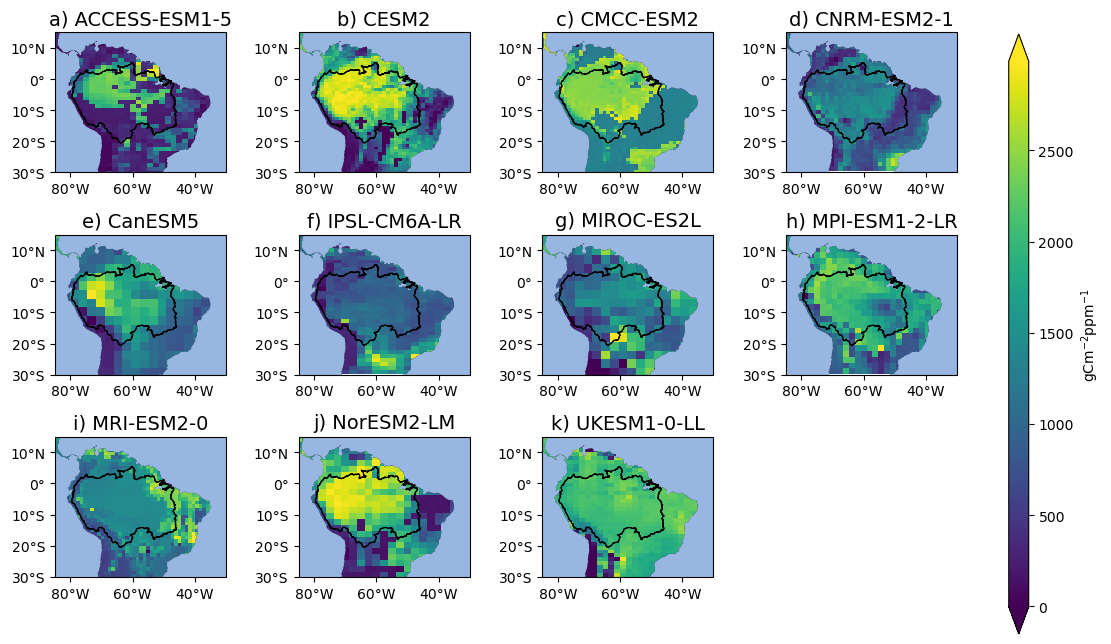

In [66]:
#### ------- Choose between the following plots:
# out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS'

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# nino_effect       # nina_effect
# nino_hist         # nina_hist
# nino_ssp          # nina_ssp
# msc
# clim_hist         # clim_ssp

# Set shapefiles of amazon and cerrado 

import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')
amz = [region for region in reader.records() if region.attributes['PFAF_ID'] == 62][0]
amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)

# reader = shpreader.Reader('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')
# amz = [region for region in reader.records() if region.attributes["ID"] == 1][0]
# cer = [region for region in reader.records() if region.attributes["ID"] == 3][0]
# amz = ShapelyFeature([amz.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.8)
# cer = ShapelyFeature([cer.geometry], ccrs.PlateCarree(), facecolor='none', edgecolor='cyan', lw=0.7)

plots = ["beta_1pctCO2"] #,"nina_effect","nina_ssp","nina_hist","nino_effect","nino_ssp","nino_hist","msc_net"] #,"nino_effect","nina_effect","msc","nino_ssp","nina_ssp"]
panels = ["a) ", "b) ", "c) ", "d) ", "e) ", "f) ", "g) ", "h) ", "i) ", "j) ", "k) "]

for to_plot in plots:

    if to_plot == "beta_1pctCO2":
        data_plot = beta_nbp
        title = "BETA_std spatially"
        cmap = "viridis"   
        cbar_label = 'gCm$^{-2}$ppm$^{-1}$'

    if to_plot == "gamma_tas_nbp_1pctCO2":
        data_plot = gamma_tas_nbp
        title = 'GAMMA_tas spatially'
        cmap = "Reds_r"   
        cbar_label = 'gCm$^{-2}$°C$^{-1}$'

    if to_plot == "gamma_mrso_nbp_1pctCO2":
        data_plot = gamma_mrso_nbp
        title = 'GAMMA_mrso spatially'
        cmap = "Blues"
        cbar_label = 'gCm$^{-2}$kgm$^{-2}$'

    if to_plot == "gamma_rsds_nbp_1pctCO2":
        data_plot = gamma_rsds_nbp
        title = 'GAMMA_rsds'
        cmap = "Purples"

    #### ------- MULTIMODEL PLOT -------- ####

    # --- Set the area: choose the min and max values for the coordinates                                                                                                                          
    # Set lat-lon limits - CUSTOM
    lon_min = -85
    lon_max = -30
    lat_min = -30 
    lat_max = 15

    # --- Plot configuration
    width_inch = 10
    height_inch = 8

    # --- Colorbar configuration#
    min_value, max_value = None, None                                       #automatic colorbar limits
    cbar_position = "top"

    # --- Title & Axes labels
    xlabel = 'longitude [deg]'
    ylabel = 'latitude [deg]'

    # Create the figure 
    fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
    gs = gridspec.GridSpec(4, 8)

    # Iteratively create subplots 
    for i,item in enumerate(esm):

        hatch = data_plot[i]["p_value"]
        data = data_plot[i]["slope_std"]

        if i < 4:
            ax = fig.add_subplot(gs[0, 2 * i : 2 * i + 2], projection = ccrs.PlateCarree())
        if ((i > 3) and (i < 8)):
            ax = fig.add_subplot(gs[1, 2 * i - 8 : 2 * i - 6], projection = ccrs.PlateCarree())
        if ((i > 7) and (i < 12)):
            ax = fig.add_subplot(gs[2, 2 * i - 16 : 2 * i -14], projection = ccrs.PlateCarree())
        if i > 11:
            ax = fig.add_subplot(gs[3, 2 * i - 21 : 2 * i -19], projection = ccrs.PlateCarree())

        lons = data.lon
        lats = data.lat   
        # min_value, max_value = -300,300        
        map1 = ax.pcolormesh(lons, lats, data,  transform = ccrs.PlateCarree(), cmap=cmap) 
        # map = ax.contourf(lons, lats, data_plot[i], vmin=min_value, vmax=max_value, transform = ccrs.PlateCarree(), cmap=cmap, norm=colors.TwoSlopeNorm(0)) 
        sign = np.ma.masked_greater(hatch, 0.05)
        # map = ax.pcolor(lons, lats, sign, hatch = '///', transform = ccrs.PlateCarree(), alpha=0)

        ax.set_extent([lon_min, lon_max, lat_min, lat_max], ccrs.PlateCarree())
        ax.coastlines()
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor=cfeature.COLORS['water']))
        ax.add_feature(amz)
        # ax.add_feature(cer)

    ## XtickLabels alternative 1
        # Longitude labels
        ax.set_xticks(np.arange(-80,lon_max,20), crs=ccrs.PlateCarree())
        lon_formatter = LONGITUDE_FORMATTER
        ax.xaxis.set_major_formatter(lon_formatter)
        #ax.set_xlabel(xlabel, **xlabel_fontstyle)
        # Latitude labels
        ax.set_yticks(np.arange(lat_min,lat_max,10), crs=ccrs.PlateCarree())
        lat_formatter = LATITUDE_FORMATTER
        ax.yaxis.set_major_formatter(lat_formatter)
        ax.set_title(panels[i] + esm[i],fontsize=14)  

    # --- Plot colorbar
    #fig.subplots_adjust(wspace=0, hspace=0)
    fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.0, hspace=0.25)
    fig.tight_layout()
    cbar_ax = fig.add_axes([1.02, 0.2, 0.02, 0.75])                     # Left, Bottom, Width, Height    
    clb = fig.colorbar(map1, cax=cbar_ax, extend="both")
    clb.set_label(cbar_label)
    # clb.ax.set_yticklabels(np.arange(-6,9,2))


    # --- Output file
    title = "BETA spatial"
    fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)    
    fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)    


## Feedback values in AMZ

1pctCO2

In [67]:
# Coefficients

beta_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in beta_nbp]
gamma_mrso_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma_mrso_nbp]
gamma_rsds_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma_rsds_nbp]
gamma_tas_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma_tas_nbp]
gamma_vpd_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma_vpd_nbp]
gamma_pr_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma_pr_nbp]

df_beta_ssp = xr.concat(beta_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "beta_ssp_lt"); df_beta_ssp = df_beta_ssp.drop(columns = "region").rename(index=dict(zip(df_beta_ssp.index, esm)))
df_gamma_mrso = xr.concat(gamma_mrso_nbp_amz, dim = "esm").to_dataframe(name = "mrso_lt"); df_gamma_mrso = df_gamma_mrso.drop(columns = "region").rename(index=dict(zip(df_gamma_mrso.index, esm)))
df_gamma_tas = xr.concat(gamma_tas_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "tas_lt"); df_gamma_tas = df_gamma_tas.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_tas.index, esm)))
df_gamma_rsds = xr.concat(gamma_rsds_nbp_amz, dim = "esm").to_dataframe(name = "rsds_lt"); df_gamma_rsds = df_gamma_rsds.drop(columns = "region").rename(index=dict(zip(df_gamma_rsds.index, esm)))
df_gamma_vpd = xr.concat(gamma_vpd_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "vpd_lt"); df_gamma_vpd = df_gamma_vpd.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_vpd.index, esm)))
df_gamma_pr = xr.concat(gamma_pr_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "pr_lt"); df_gamma_pr = df_gamma_pr.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_pr.index, esm)))

df_amz_lt = pd.concat([df_beta_ssp,df_gamma_mrso, df_gamma_tas, df_gamma_rsds, df_gamma_vpd, df_gamma_pr], axis = 1)

In [68]:
# Standardized coefficients

beta_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in beta_nbp]
gamma_mrso_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma_mrso_nbp]
gamma_rsds_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma_rsds_nbp]
gamma_tas_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma_tas_nbp]
gamma_vpd_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma_vpd_nbp]
gamma_pr_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma_pr_nbp]

df_beta_ssp = xr.concat(beta_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "beta_ssp_lt_std"); df_beta_ssp = df_beta_ssp.drop(columns = "region").rename(index=dict(zip(df_beta_ssp.index, esm)))
df_gamma_mrso = xr.concat(gamma_mrso_nbp_amz, dim = "esm").to_dataframe(name = "mrso_lt_std"); df_gamma_mrso = df_gamma_mrso.drop(columns = "region").rename(index=dict(zip(df_gamma_mrso.index, esm)))
df_gamma_tas = xr.concat(gamma_tas_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "tas_lt_std"); df_gamma_tas = df_gamma_tas.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_tas.index, esm)))
df_gamma_rsds = xr.concat(gamma_rsds_nbp_amz, dim = "esm").to_dataframe(name = "rsds_lt_std"); df_gamma_rsds = df_gamma_rsds.drop(columns = "region").rename(index=dict(zip(df_gamma_rsds.index, esm)))
df_gamma_vpd = xr.concat(gamma_vpd_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "vpd_lt_std"); df_gamma_vpd = df_gamma_vpd.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_vpd.index, esm)))
df_gamma_pr = xr.concat(gamma_pr_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "pr_lt_std"); df_gamma_pr = df_gamma_pr.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_pr.index, esm)))

df_amz_lt_std = pd.concat([df_beta_ssp,df_gamma_mrso, df_gamma_tas, df_gamma_rsds, df_gamma_vpd, df_gamma_pr], axis = 1)

In [69]:
# Predicted contribution on DeltaC

beta_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in beta_nbp]
gamma_mrso_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma_mrso_nbp]
gamma_rsds_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma_rsds_nbp]
gamma_tas_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma_tas_nbp]
gamma_vpd_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma_vpd_nbp]
gamma_pr_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma_pr_nbp]

df_beta_ssp = xr.concat(beta_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "beta_ssp_lt"); df_beta_ssp = df_beta_ssp.drop(columns = "region").rename(index=dict(zip(df_beta_ssp.index, esm)))
df_gamma_mrso = xr.concat(gamma_mrso_nbp_amz, dim = "esm").to_dataframe(name = "mrso_lt"); df_gamma_mrso = df_gamma_mrso.drop(columns = "region").rename(index=dict(zip(df_gamma_mrso.index, esm)))
df_gamma_tas = xr.concat(gamma_tas_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "tas_lt"); df_gamma_tas = df_gamma_tas.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_tas.index, esm)))
df_gamma_rsds = xr.concat(gamma_rsds_nbp_amz, dim = "esm").to_dataframe(name = "rsds_lt"); df_gamma_rsds = df_gamma_rsds.drop(columns = "region").rename(index=dict(zip(df_gamma_rsds.index, esm)))
df_gamma_vpd = xr.concat(gamma_vpd_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "vpd_lt"); df_gamma_vpd = df_gamma_vpd.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_vpd.index, esm)))
df_gamma_pr = xr.concat(gamma_pr_nbp_amz, dim = "esm", coords = "minimal", compat = "override").to_dataframe(name = "pr_lt"); df_gamma_pr = df_gamma_pr.drop(columns = ["region"]).rename(index=dict(zip(df_gamma_pr.index, esm)))

df_amz_lt_contr = pd.concat([df_beta_ssp,df_gamma_mrso, df_gamma_tas, df_gamma_rsds, df_gamma_vpd, df_gamma_pr], axis = 1)
df_amz_lt_contr = df_amz_lt_contr.reset_index()
model_mapping = {i: esm[i] for i in range(len(esm))}

# Map numeric values in 'esm' column to model names
df_amz_lt_contr = df_amz_lt_contr.reset_index()
df_amz_lt_contr['esm'] = df_amz_lt_contr['esm'].map(model_mapping)
df_amz_lt_contr.drop(columns = "height", inplace = True)

ssp585

In [70]:
# Standardized coefficients

beta585_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in beta585_nbp]
gamma585_mrso_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma585_mrso_nbp]
gamma585_rsds_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma585_rsds_nbp]
gamma585_tas_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma585_tas_nbp]
gamma585_vpd_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma585_vpd_nbp]
gamma585_pr_nbp_amz = [zonal_stat(a["slope"].astype("float64"), geodf).sel(region = 1) for a in gamma585_pr_nbp]

df_beta585_ssp = xr.concat(beta585_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "beta_ssp_lt585"); df_beta585_ssp = df_beta585_ssp.drop(columns = "region").rename(index=dict(zip(df_beta585_ssp.index, models)))
df_gamma585_mrso = xr.concat(gamma585_mrso_nbp_amz, dim = "models").to_dataframe(name = "mrso_lt585"); df_gamma585_mrso = df_gamma585_mrso.drop(columns = "region").rename(index=dict(zip(df_gamma585_mrso.index, models)))
df_gamma585_tas = xr.concat(gamma585_tas_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "tas_lt585"); df_gamma585_tas = df_gamma585_tas.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_tas.index, models)))
df_gamma585_rsds = xr.concat(gamma585_rsds_nbp_amz, dim = "models").to_dataframe(name = "rsds_lt585"); df_gamma585_rsds = df_gamma585_rsds.drop(columns = "region").rename(index=dict(zip(df_gamma585_rsds.index, models)))
df_gamma585_vpd = xr.concat(gamma585_vpd_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "vpd_lt585"); df_gamma585_vpd = df_gamma585_vpd.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_vpd.index, models)))
df_gamma585_pr = xr.concat(gamma585_pr_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "pr_lt585"); df_gamma585_pr = df_gamma585_pr.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_pr.index, models)))

df_amz_lt585 = pd.concat([df_beta585_ssp,df_gamma585_mrso, df_gamma585_tas, df_gamma585_rsds, df_gamma585_vpd, df_gamma585_pr], axis = 1)
df_amz_lt585.drop(columns = "height", inplace = True)

In [71]:
# Standardized coefficients

beta585_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in beta585_nbp]
gamma585_mrso_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma585_mrso_nbp]
gamma585_rsds_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma585_rsds_nbp]
gamma585_tas_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma585_tas_nbp]
gamma585_vpd_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma585_vpd_nbp]
gamma585_pr_nbp_amz = [zonal_stat(a["slope_std"].astype("float64"), geodf).sel(region = 1) for a in gamma585_pr_nbp]

df_beta585_ssp = xr.concat(beta585_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "beta_ssp_lt_std"); df_beta585_ssp = df_beta585_ssp.drop(columns = "region").rename(index=dict(zip(df_beta585_ssp.index, models)))
df_gamma585_mrso = xr.concat(gamma585_mrso_nbp_amz, dim = "models").to_dataframe(name = "mrso_lt_std"); df_gamma585_mrso = df_gamma585_mrso.drop(columns = "region").rename(index=dict(zip(df_gamma585_mrso.index, models)))
df_gamma585_tas = xr.concat(gamma585_tas_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "tas_lt_std"); df_gamma585_tas = df_gamma585_tas.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_tas.index, models)))
df_gamma585_rsds = xr.concat(gamma585_rsds_nbp_amz, dim = "models").to_dataframe(name = "rsds_lt_std"); df_gamma585_rsds = df_gamma585_rsds.drop(columns = "region").rename(index=dict(zip(df_gamma585_rsds.index, models)))
df_gamma585_vpd = xr.concat(gamma585_vpd_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "vpd_lt_std"); df_gamma585_vpd = df_gamma585_vpd.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_vpd.index, models)))
df_gamma585_pr = xr.concat(gamma585_pr_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "pr_lt_std"); df_gamma585_pr = df_gamma585_pr.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_pr.index, models)))

df_amz_lt585_std = pd.concat([df_beta585_ssp,df_gamma585_mrso, df_gamma585_tas, df_gamma585_rsds, df_gamma585_vpd, df_gamma585_pr], axis = 1)
df_amz_lt585_std.drop(columns = "height", inplace = True)

In [72]:
# Predicted contribution on DeltaC

beta585_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in beta585_nbp]
gamma585_mrso_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma585_mrso_nbp]
gamma585_rsds_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma585_rsds_nbp]
gamma585_tas_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma585_tas_nbp]
gamma585_vpd_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma585_vpd_nbp]
gamma585_pr_nbp_amz = [zonal_stat(a["y_pred"].astype("float64"), geodf).sel(region = 1) for a in gamma585_pr_nbp]

df_beta585_ssp = xr.concat(beta585_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "beta_ssp_lt585"); df_beta585_ssp = df_beta585_ssp.drop(columns = "region").rename(index=dict(zip(df_beta585_ssp.index, models)))
df_gamma585_mrso = xr.concat(gamma585_mrso_nbp_amz, dim = "models").to_dataframe(name = "mrso_lt585"); df_gamma585_mrso = df_gamma585_mrso.drop(columns = "region").rename(index=dict(zip(df_gamma585_mrso.index, models)))
df_gamma585_tas = xr.concat(gamma585_tas_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "tas_lt585"); df_gamma585_tas = df_gamma585_tas.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_tas.index, models)))
df_gamma585_rsds = xr.concat(gamma585_rsds_nbp_amz, dim = "models").to_dataframe(name = "rsds_lt585"); df_gamma585_rsds = df_gamma585_rsds.drop(columns = "region").rename(index=dict(zip(df_gamma585_rsds.index, models)))
df_gamma585_vpd = xr.concat(gamma585_vpd_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "vpd_lt585"); df_gamma585_vpd = df_gamma585_vpd.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_vpd.index, models)))
df_gamma585_pr = xr.concat(gamma585_pr_nbp_amz, dim = "models", coords = "minimal", compat = "override").to_dataframe(name = "pr_lt585"); df_gamma585_pr = df_gamma585_pr.drop(columns = ["region"]).rename(index=dict(zip(df_gamma585_pr.index, models)))

df_amz_lt585_contr = pd.concat([df_beta585_ssp,df_gamma585_mrso, df_gamma585_tas, df_gamma585_rsds, df_gamma585_vpd, df_gamma585_pr], axis = 1)
df_amz_lt585_contr = df_amz_lt585_contr.reset_index()
models_mapping = {i: models[i] for i in range(len(models))}

# Map numeric values in 'models' column to models names
df_amz_lt585_contr = df_amz_lt585_contr.reset_index()
df_amz_lt585_contr['models'] = df_amz_lt585_contr['models'].map(models_mapping)
df_amz_lt585_contr.drop(columns = "height", inplace = True)

#### Barplots

BETA and GAMMA

<AxesSubplot: xlabel='models'>

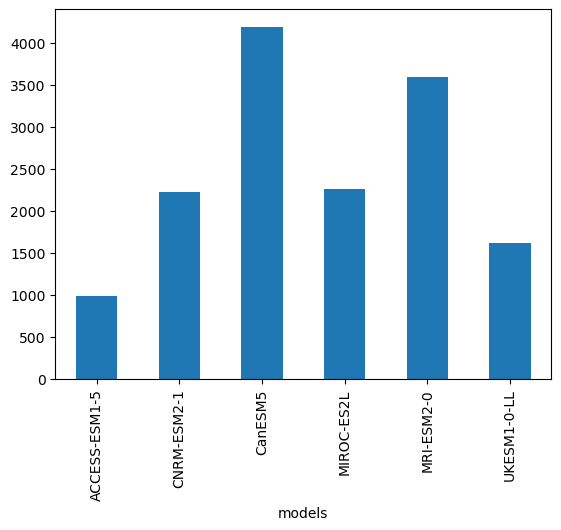

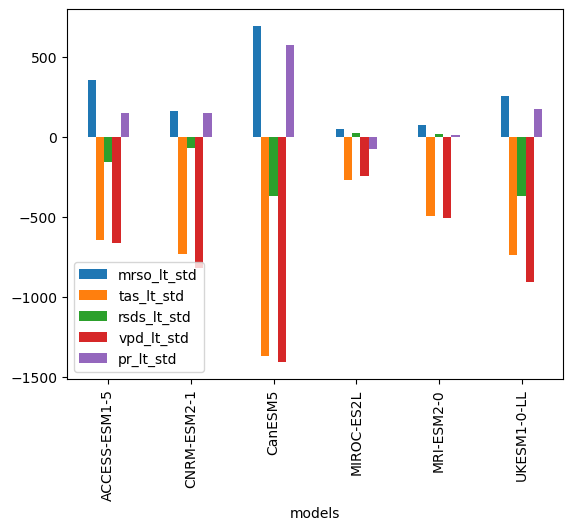

In [ ]:
df_amz_lt585_std["beta_ssp_lt_std"].plot.bar(stacked = False)
df_amz_lt585_std.drop(columns=["beta_ssp_lt_std"]).plot.bar(stacked=False)


##### BETA and GAMMA

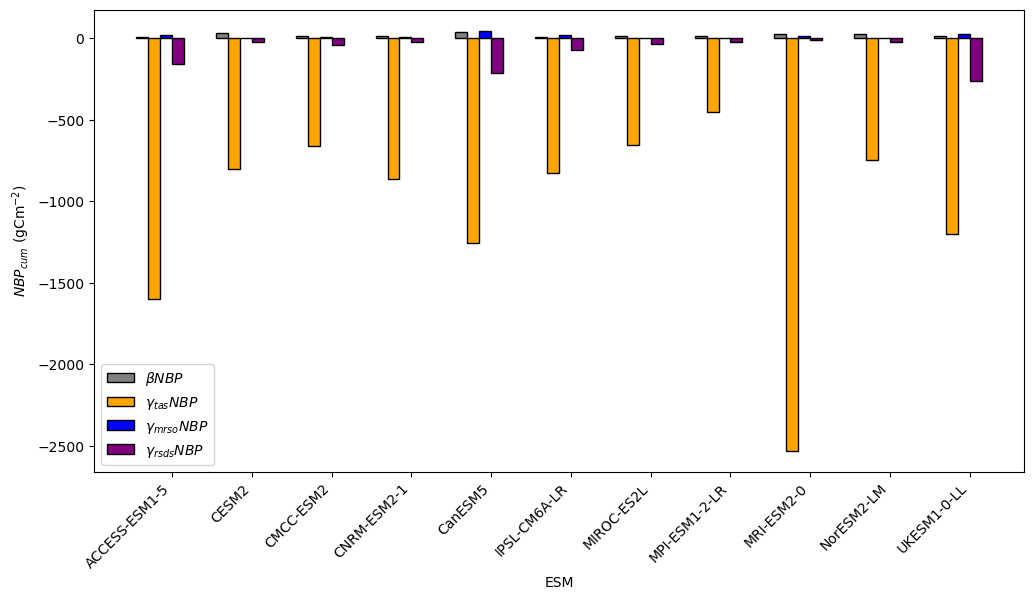

In [81]:
# df_amz_lt.plot.bar(stacked = False)

import numpy as np
import matplotlib.pyplot as plt

# Example dataset
# Assuming df_amz_lt is defined with the required columns and index

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Number of bars and width
num_bars = 6  # The number of different bars
bar_width = 0.15  # Width of each bar

# Set positions for each set of bars
indices = np.arange(len(df_amz_lt.index))

# Plot side-by-side bars
bar1 = ax.bar(indices - 2.5*bar_width, df_amz_lt['beta_ssp_lt'], width=bar_width, label='$\u03B2 NBP$', color='gray', edgecolor='black')
bar2 = ax.bar(indices - 1.5*bar_width, df_amz_lt['tas_lt'], width=bar_width, label='$\gamma_{tas} NBP$', color='orange', edgecolor='black')
bar3 = ax.bar(indices - 0.5*bar_width, df_amz_lt['mrso_lt'], width=bar_width, label='$\gamma_{mrso} NBP$', color='blue', edgecolor='black')
# bar4 = ax.bar(indices + 0.5*bar_width, df_amz_lt['pr_lt'], width=bar_width, label='$\gamma_{pr} NBP$', color='skyblue', edgecolor='black')
bar5 = ax.bar(indices + 0.5*bar_width, df_amz_lt['rsds_lt'], width=bar_width, label='$\gamma_{rsds} NBP$', color='purple', edgecolor='black')
# bar6 = ax.bar(indices + 2.5*bar_width, df_amz_lt['vpd_lt'], width=bar_width, label='$\gamma_{vpd} NBP$', color='red', edgecolor='black')

# Add labels and title
ax.set_xlabel('ESM')
ax.set_ylabel("$NBP_{cum}$ (gCm$^{-2}$)")
# ax.set_title('')

# Set x-axis tick positions to the middle of the groups
ax.set_xticks(indices)
ax.set_xticklabels(df_amz_lt.index)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show legend
ax.legend()

# Display the plot
plt.show()


##### Standardized BETA and GAMMA

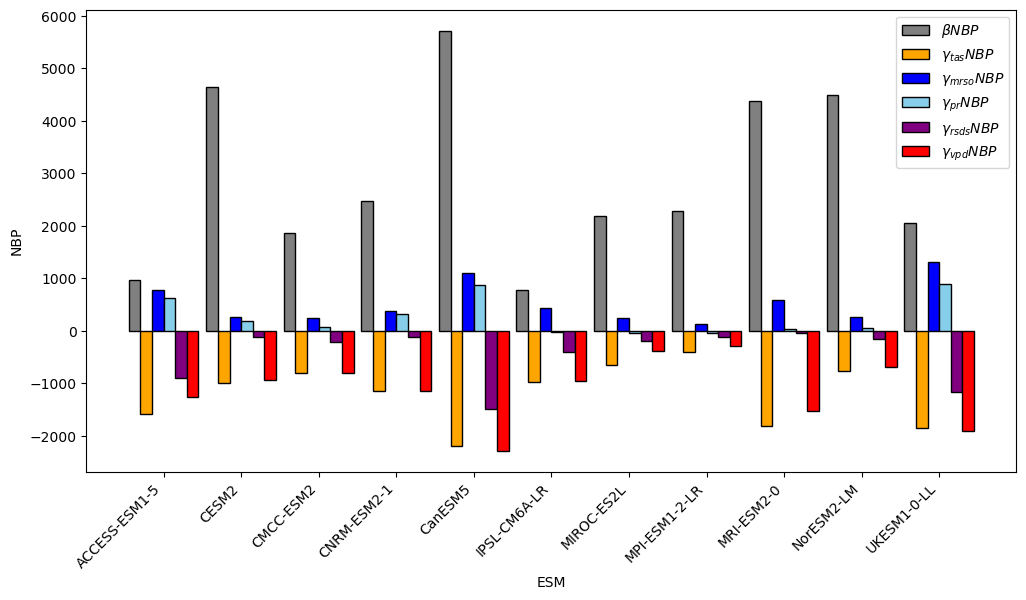

In [ ]:
# df_amz_lt_std.plot.bar(stacked = False)

import numpy as np
import matplotlib.pyplot as plt

# Example dataset
# Assuming df_amz_lt_std is defined with the required columns and index

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Number of bars and width
num_bars = 6  # The number of different bars
bar_width = 0.15  # Width of each bar

# Set positions for each set of bars
indices = np.arange(len(df_amz_lt_std.index))

# Plot side-by-side bars
bar1 = ax.bar(indices - 2.5*bar_width, df_amz_lt_std['beta_ssp_lt_std'], width=bar_width, label='$\u03B2 NBP$', color='gray', edgecolor='black')
bar2 = ax.bar(indices - 1.5*bar_width, df_amz_lt_std['tas_lt_std'], width=bar_width, label='$\gamma_{tas} NBP$', color='orange', edgecolor='black')
bar3 = ax.bar(indices - 0.5*bar_width, df_amz_lt_std['mrso_lt_std'], width=bar_width, label='$\gamma_{mrso} NBP$', color='blue', edgecolor='black')
bar4 = ax.bar(indices + 0.5*bar_width, df_amz_lt_std['pr_lt_std'], width=bar_width, label='$\gamma_{pr} NBP$', color='skyblue', edgecolor='black')
bar5 = ax.bar(indices + 1.5*bar_width, df_amz_lt_std['rsds_lt_std'], width=bar_width, label='$\gamma_{rsds} NBP$', color='purple', edgecolor='black')
bar6 = ax.bar(indices + 2.5*bar_width, df_amz_lt_std['vpd_lt_std'], width=bar_width, label='$\gamma_{vpd} NBP$', color='red', edgecolor='black')

# Add labels and title
ax.set_xlabel('ESM')
ax.set_ylabel('NBP')
ax.set_title('')

# Set x-axis tick positions to the middle of the groups
ax.set_xticks(indices)
ax.set_xticklabels(df_amz_lt_std.index)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show legend
ax.legend()

# Display the plot
plt.show()


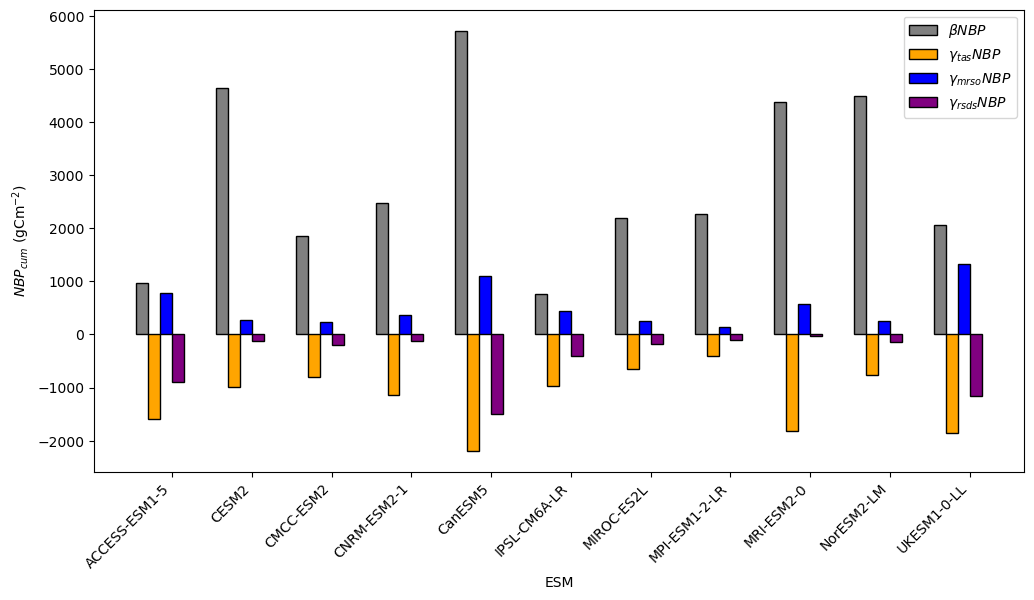

In [74]:
# df_amz_lt_std.plot.bar(stacked = False)

import numpy as np
import matplotlib.pyplot as plt

# Example dataset
# Assuming df_amz_lt_std is defined with the required columns and index

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Number of bars and width
num_bars = 6  # The number of different bars
bar_width = 0.15  # Width of each bar

# Set positions for each set of bars
indices = np.arange(len(df_amz_lt_std.index))

# Plot side-by-side bars
bar1 = ax.bar(indices - 2.5*bar_width, df_amz_lt_std['beta_ssp_lt_std'], width=bar_width, label='$\u03B2 NBP$', color='gray', edgecolor='black')
bar2 = ax.bar(indices - 1.5*bar_width, df_amz_lt_std['tas_lt_std'], width=bar_width, label='$\gamma_{tas} NBP$', color='orange', edgecolor='black')
bar3 = ax.bar(indices - 0.5*bar_width, df_amz_lt_std['mrso_lt_std'], width=bar_width, label='$\gamma_{mrso} NBP$', color='blue', edgecolor='black')
# bar4 = ax.bar(indices + 0.5*bar_width, df_amz_lt_std['pr_lt_std'], width=bar_width, label='$\gamma_{pr} NBP$', color='skyblue', edgecolor='black')
bar5 = ax.bar(indices + 0.5*bar_width, df_amz_lt_std['rsds_lt_std'], width=bar_width, label='$\gamma_{rsds} NBP$', color='purple', edgecolor='black')
# bar6 = ax.bar(indices + 2.5*bar_width, df_amz_lt_std['vpd_lt_std'], width=bar_width, label='$\gamma_{vpd} NBP$', color='red', edgecolor='black')

# Add labels and title
ax.set_xlabel('ESM')
ax.set_ylabel("$NBP_{cum}$ (gCm$^{-2}$)")
# ax.set_title('')

# Set x-axis tick positions to the middle of the groups
ax.set_xticks(indices)
ax.set_xticklabels(df_amz_lt_std.index)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show legend
ax.legend()

# Display the plot
plt.show()
plt.close()

title = "BETA_GAMMA feedbacks"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)    
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)  

Long-term trends

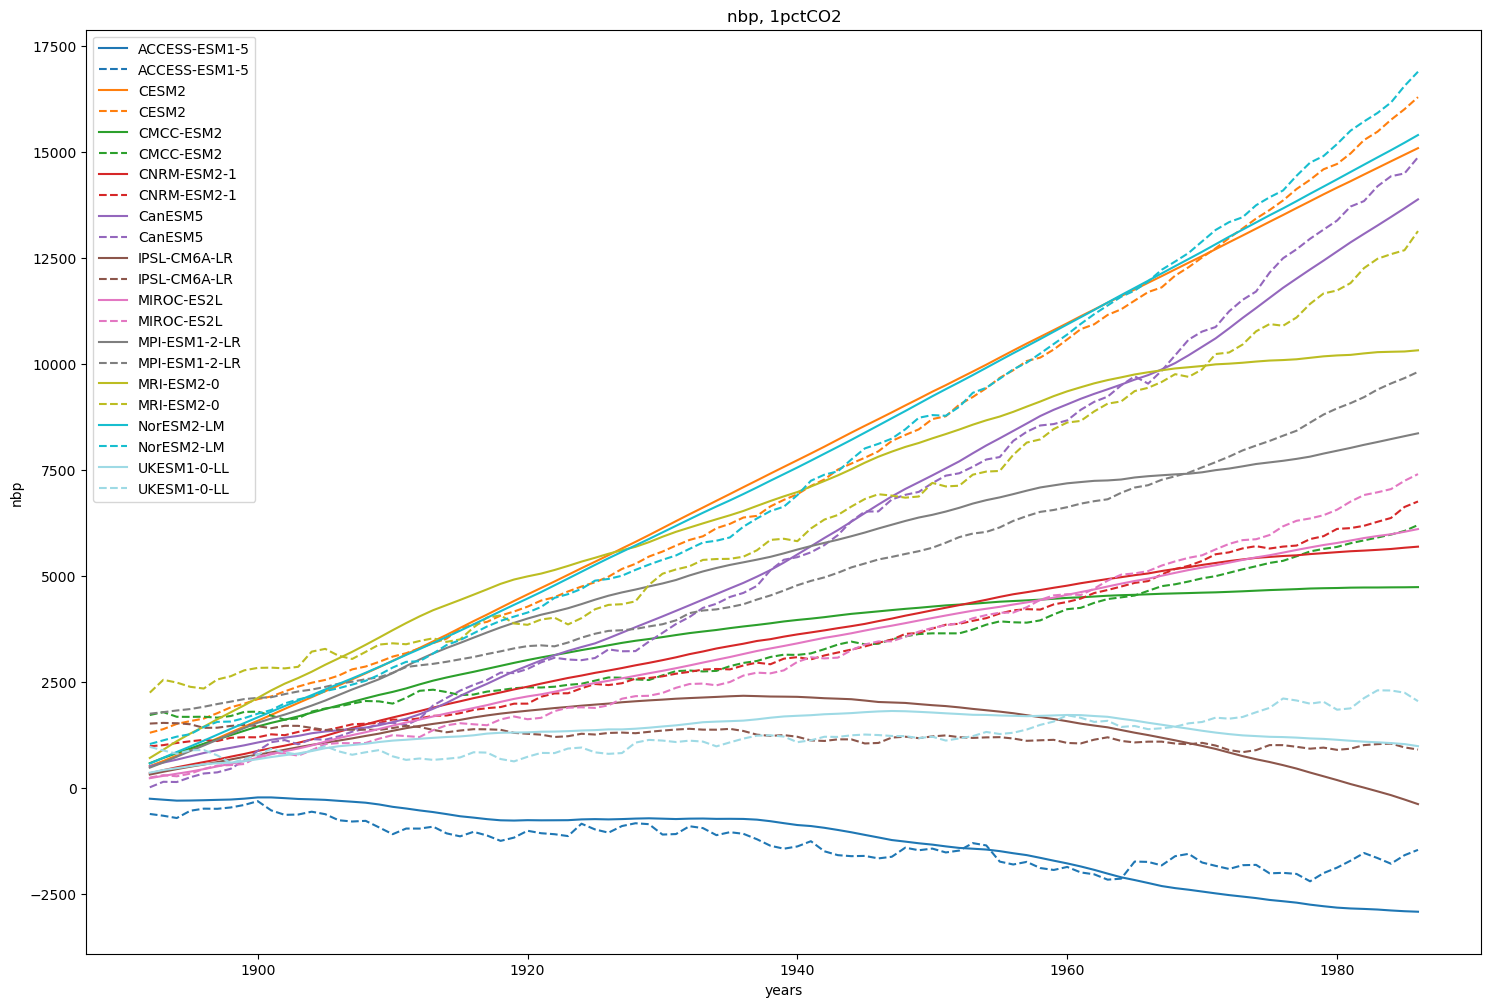

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig, ax = plt.subplots(1, 1, figsize=(18, 12))  # 3x3 grid
fig.subplots_adjust(hspace=0.4, wspace=0.4)       # Spacing between plots

# Define colors for each model
cmap = plt.cm.get_cmap('tab20', len(esm))
colors = [cmap(i) for i in range(len(esm))]

# List of variables (columns) to plot, assuming df_rad_amz has the required columns
variables = ["nep", "nbp", "tas", "mrso", "rsds", "vpd", "pr"]

# Plot each variable in its own subplot
# ax = axes.flatten()[i]   # Flatten the 3x3 grid to index subplots linearly
for m, mm in enumerate(esm):
    delta_nbp = pd.DataFrame(df_rad_amz[f'{"nbp"} ' + mm].cumsum() + df_bgc_amz[f'{"nbp"} ' + mm].cumsum()); delta_nbp = (delta_nbp.iloc[36:] - delta_nbp.iloc[36]).reset_index()
    ax.plot(delta_nbp["time"], delta_nbp.rolling(10, center=True).mean(), label=mm, color=colors[m])

    delta_nbp_pred = df_amz_lt_contr[df_amz_lt_contr["esm"] == mm]; delta_nbp_pred["pred"] = delta_nbp_pred["beta_ssp_lt"] + delta_nbp_pred["tas_lt"] ; #delta_nbp_pred["pred"] = delta_nbp_pred["pred"].iloc[:] - delta_nbp_pred["pred"].iloc[0] 
    ax.plot(delta_nbp_pred["time"], delta_nbp_pred["pred"].rolling(10, center=True).mean(), label=mm, color=colors[m], linestyle = "dashed")

    # Set labels and title
    ax.set_xlabel("years")
    ax.set_ylabel("nbp")
    # ax.set_ylim(-80, 1400)
    ax.set_title("nbp, 1pctCO2")

# Add legend on the last non-empty plot
ax.legend(loc='upper left')

plt.show()


### Scatterplots 1pctCO2

In [75]:
df_cum585 = df_amz_lt585.copy().reset_index()
for m, mm in enumerate(models):
    df_cum585.loc[df_cum585["models"] == mm, "nbp_delta_bgc"] = (df_bgc585_amz.cumsum().iloc[-1]["nbp " + mm] - df_bgc585_amz.cumsum().iloc[0]["nbp " + mm])
    df_cum585.loc[df_cum585["models"] == mm, "nbp_delta_rad"] = (df_rad585_amz.cumsum().iloc[-1]["nbp " + mm] - df_rad585_amz.cumsum().iloc[0]["nbp " + mm])
    df_cum585.loc[df_cum585["models"] == mm, "nbp_pred_beta"] = df_amz_lt585_contr[df_amz_lt585_contr["models"] == mm].iloc[-1]["beta_ssp_lt585"]
    df_cum585.loc[df_cum585["models"] == mm, "nbp_pred_mrso"] = df_amz_lt585_contr[df_amz_lt585_contr["models"] == mm].iloc[-1]["mrso_lt585"]
    df_cum585.loc[df_cum585["models"] == mm, "nbp_pred_tas"] = df_amz_lt585_contr[df_amz_lt585_contr["models"] == mm].iloc[-1]["tas_lt585"]
    df_cum585.loc[df_cum585["models"] == mm, "nbp_pred_vpd"] = df_amz_lt585_contr[df_amz_lt585_contr["models"] == mm].iloc[-1]["vpd_lt585"]
    
df_cum585["nbp_tot"] = df_cum585["nbp_delta_bgc"] + df_cum585["nbp_delta_rad"]
df_cum585 = df_cum585.set_index("models") 
df_cum585 = pd.concat([df_cum585, df_amz_lt585_std], axis = 1)
df_cum585.index.rename("esm", inplace = "True")
df_cum585["simulation"] = "ssp585"
df_cum585

,beta_ssp_lt585,mrso_lt585,tas_lt585,rsds_lt585,vpd_lt585,pr_lt585,nbp_delta_bgc,nbp_delta_rad,nbp_pred_beta,nbp_pred_mrso,nbp_pred_tas,nbp_pred_vpd,nbp_tot,beta_ssp_lt_std,mrso_lt_std,tas_lt_std,rsds_lt_std,vpd_lt_std,pr_lt_std,simulation
esm,,,,,,,,,,,,,,,,,,,,
ACCESS-ESM1-5,4.436964,10.210716,-1051.130636,-67.965720,-1338.984043,10.235560,3285.630714,-6183.844797,3522.431460,-2906.243936,-4468.800349,-4143.953231,-2898.214084,977.718767,736.282334,-1562.547165,-444.336226,-1418.619880,344.466232,ssp585
CNRM-ESM2-1,10.062027,1.788410,-1123.754111,-2.609681,-1543.031888,9.344752,7367.759705,-7214.041925,7776.110874,-2688.784381,-6398.085763,-6353.428358,153.717779,2217.244104,272.104856,-1927.468578,-19.491115,-1858.516273,189.430483,ssp585
CanESM5,19.227145,21.953053,-1007.584950,-69.225416,-948.150241,21.188504,14541.878302,-11146.745709,12911.033288,-4531.453166,-8265.635390,-7720.254891,3395.132592,4236.847323,991.687863,-2668.203844,-699.261627,-2367.088895,745.824779,ssp585
MIROC-ES2L,10.236153,1.228144,-420.087923,-10.998479,-583.635922,-4.097229,7450.273779,-3259.037660,7729.899490,-1645.808659,-2648.978685,-2453.310998,4191.236119,2255.614064,229.876553,-613.917541,-78.930123,-535.030184,-92.438145,ssp585
MRI-ESM2-0,16.326579,3.152453,-1258.845464,-6.857897,-1964.754121,1.046543,12320.476569,-5672.249006,12030.471289,-2259.647886,-4674.352978,-4429.544996,6648.227563,3597.685636,334.838843,-1395.862253,-34.848889,-1286.578876,37.403495,ssp585
UKESM1-0-LL,7.333875,9.600138,-804.244630,-153.074819,-1047.218978,12.591543,5324.899911,-8205.507315,5548.613747,-3598.022750,-7338.920632,-7643.101778,-2880.607403,1616.075069,687.921025,-2264.350112,-1066.527419,-2217.021546,343.174238,ssp585


In [76]:
df_cum = df_amz_lt.copy().reset_index()
for m, mm in enumerate(esm):
    df_cum.loc[df_cum["esm"] == mm, "nbp_delta_bgc"] = (df_bgc_amz.cumsum().iloc[-1]["nbp " + mm] - df_bgc_amz.cumsum().iloc[0]["nbp " + mm])
    df_cum.loc[df_cum["esm"] == mm, "nbp_delta_rad"] = (df_rad_amz.cumsum().iloc[-1]["nbp " + mm] - df_rad_amz.cumsum().iloc[0]["nbp " + mm])
    df_cum.loc[df_cum["esm"] == mm, "nbp_pred_beta"] = df_amz_lt_contr[df_amz_lt_contr["esm"] == mm].iloc[-1]["beta_ssp_lt"]
    df_cum.loc[df_cum["esm"] == mm, "nbp_pred_mrso"] = df_amz_lt_contr[df_amz_lt_contr["esm"] == mm].iloc[-1]["mrso_lt"]
    df_cum.loc[df_cum["esm"] == mm, "nbp_pred_tas"] = df_amz_lt_contr[df_amz_lt_contr["esm"] == mm].iloc[-1]["tas_lt"]
    df_cum.loc[df_cum["esm"] == mm, "nbp_pred_vpd"] = df_amz_lt_contr[df_amz_lt_contr["esm"] == mm].iloc[-1]["vpd_lt"]



df_cum = df_cum.drop(columns = "height")
df_cum["nbp_tot"] = df_cum["nbp_delta_bgc"] + df_cum["nbp_delta_rad"]
df_cum = df_cum.set_index("esm") 
df_cum = pd.concat([df_cum, df_amz_lt_std], axis = 1)
df_cum["simulation"] = "1pctCO2"
df_cum

,beta_ssp_lt,mrso_lt,tas_lt,rsds_lt,vpd_lt,pr_lt,nbp_delta_bgc,nbp_delta_rad,nbp_pred_beta,nbp_pred_mrso,...,nbp_pred_vpd,nbp_tot,beta_ssp_lt_std,mrso_lt_std,tas_lt_std,rsds_lt_std,height,vpd_lt_std,pr_lt_std,simulation
esm,,,,,,,,,,,,,,,,,,,,,
ACCESS-ESM1-5,5.989779,20.458483,-1600.172338,-160.538951,-1007.248661,2.216436,5963.976300,-8521.975421,5082.209915,-3932.012024,...,-4350.488962,-2557.999121,964.788716,779.143865,-1591.673537,-893.881319,2.0,-1251.050270,622.572056,1pctCO2
CESM2,28.833852,3.640380,-801.174459,-22.480650,-735.579733,0.913083,23369.153621,-5018.864477,21732.566546,-2160.860287,...,-3598.410166,18350.289144,4644.340493,264.247839,-984.898724,-116.550169,2.0,-941.859694,196.399521,1pctCO2
CMCC-ESM2,11.553391,9.389904,-659.828871,-45.088347,-484.142720,0.500075,11465.878039,-2870.000056,9284.204962,-1230.584394,...,-1964.940791,8595.877984,1860.933452,243.618923,-809.539215,-206.277577,2.0,-809.796867,82.091155,1pctCO2
CNRM-ESM2-1,15.338908,4.624916,-861.725452,-23.168099,-575.297853,1.476053,12644.118019,-5561.313475,11907.004651,-2210.237584,...,-3688.263261,7082.804544,2470.676156,372.094367,-1137.043313,-122.583819,2.0,-1139.461977,320.708064,1pctCO2
CanESM5,35.508549,45.974638,-1257.279002,-212.357881,-747.925194,2.795048,28079.383197,-11502.396843,26021.194358,-6077.810730,...,-9292.867506,16576.986354,5719.450658,1109.329664,-2187.169139,-1496.536380,2.0,-2281.755989,875.230714,1pctCO2
IPSL-CM6A-LR,4.781316,17.938463,-827.372375,-71.093963,-859.290309,-1.123142,5703.545509,-5119.018162,5105.683255,-2459.033248,...,-4192.351908,584.527348,770.138531,439.757491,-970.890604,-400.441527,2.0,-955.283393,-27.693635,1pctCO2
MIROC-ES2L,13.612931,0.850837,-655.775736,-35.067834,-246.420917,-0.201368,11835.955808,-3964.862401,10766.841897,-2258.424564,...,-1916.524992,7871.093407,2192.668820,252.897535,-646.738897,-185.667380,2.0,-387.240719,-37.815533,1pctCO2
MPI-ESM1-2-LR,14.130601,-0.180399,-451.513632,-21.518093,-275.166152,-0.148782,13891.246715,-1732.977091,12017.011763,-960.532848,...,-1105.775328,12158.269624,2276.051221,132.027597,-399.540419,-113.733969,2.0,-289.518703,-34.069454,1pctCO2
MRI-ESM2-0,27.178978,14.704041,-2528.235897,-14.006589,-3353.747292,0.024750,23502.323241,-10714.058261,21858.656632,-4361.600462,...,-6281.339473,12788.264980,4377.785795,578.861171,-1812.582035,-33.986479,2.0,-1524.120962,37.335583,1pctCO2


In [77]:
# df_cum585[["beta_ssp_lt_std", "mrso_lt_std", "tas_lt_std", "nbp_delta_rad", "nbp_tot", "simulation"]]
test = df_cum[["beta_ssp_lt_std", "mrso_lt_std", "tas_lt_std", "nbp_delta_rad", "nbp_tot", "simulation"]].reset_index()
test = test.melt(id_vars = ["esm", "simulation"])

test1 = df_cum585[["beta_ssp_lt_std", "mrso_lt_std", "tas_lt_std", "nbp_delta_rad", "nbp_tot", "simulation"]].reset_index()
test1 = test1.melt(id_vars = ["esm", "simulation"])

final = pd.concat([test, test1], axis = 0)
final = final.pivot(index=['esm', 'simulation'], columns='variable', values='value').reset_index()
final

variable,esm,simulation,beta_ssp_lt_std,mrso_lt_std,nbp_delta_rad,nbp_tot,tas_lt_std
0,ACCESS-ESM1-5,1pctCO2,964.788716,779.143865,-8521.975421,-2557.999121,-1591.673537
1,ACCESS-ESM1-5,ssp585,977.718767,736.282334,-6183.844797,-2898.214084,-1562.547165
2,CESM2,1pctCO2,4644.340493,264.247839,-5018.864477,18350.289144,-984.898724
3,CMCC-ESM2,1pctCO2,1860.933452,243.618923,-2870.000056,8595.877984,-809.539215
4,CNRM-ESM2-1,1pctCO2,2470.676156,372.094367,-5561.313475,7082.804544,-1137.043313
5,CNRM-ESM2-1,ssp585,2217.244104,272.104856,-7214.041925,153.717779,-1927.468578
6,CanESM5,1pctCO2,5719.450658,1109.329664,-11502.396843,16576.986354,-2187.169139
7,CanESM5,ssp585,4236.847323,991.687863,-11146.745709,3395.132592,-2668.203844
8,IPSL-CM6A-LR,1pctCO2,770.138531,439.757491,-5119.018162,584.527348,-970.890604
9,MIROC-ES2L,1pctCO2,2192.668820,252.897535,-3964.862401,7871.093407,-646.738897


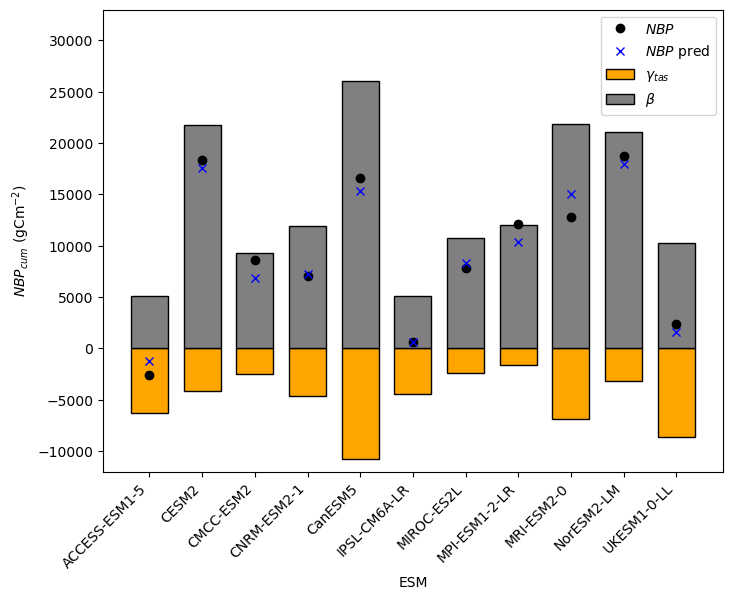

In [79]:
# Set up the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the stacked bars for `nbp_pred_beta` and `nbp_pred_tas`
bar1 = ax.bar(df_cum.index, df_cum['nbp_pred_tas'], label='$\gamma_{tas}$', color='orange', edgecolor='black', width = 0.7)
bar2 = ax.bar(df_cum.index, df_cum['nbp_pred_beta'], label='$\u03B2$', color='gray', edgecolor='black', width = 0.7)

# Plot the points for `delta_sum`
ax.plot(df_cum.index, (df_cum['nbp_delta_bgc'] + df_cum['nbp_delta_rad']), 'o', color='black', label='$NBP$')
ax.plot(df_cum.index, (df_cum['nbp_pred_beta'] + df_cum['nbp_pred_tas']), 'x', color='blue', label='$NBP$ pred', )

# Add labels and title
ax.set_ylim(-12000, 33e3)
ax.set_xlabel('ESM')
ax.set_ylabel("$NBP_{cum}$ (gCm$^{-2}$)")
ax.set_title('')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show legend
ax.legend()

# Display the plot
plt.show()

title = "BETA_GAMMA"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)  

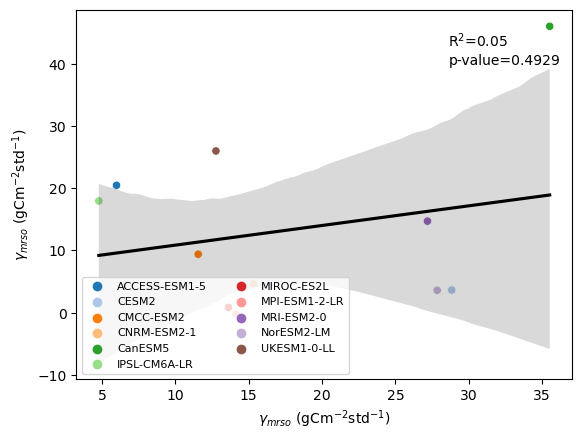

In [76]:
import seaborn as sns
from scipy import stats


fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot(x = "beta_ssp_lt", y = "mrso_lt", data=df_cum, hue=df_cum.index, palette="tab20")
ax = sns.regplot(x="beta_ssp_lt", y = "mrso_lt", data=df_cum, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\gamma_{mrso}$ (gCm$^{-2}$std$^{-1}$)", ylabel= "$\gamma_{mrso}$ (gCm$^{-2}$std$^{-1}$)")
ax.text(.75, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_cum['beta_ssp_lt'],df_cum["mrso_lt"]).rvalue**2),
    transform=ax.transAxes, fontsize = 10)
ax.text(.75, .85, 'p-value={:.4f}'.format(stats.linregress(df_cum['beta_ssp_lt'],df_cum["mrso_lt"]).pvalue),
    transform=ax.transAxes, fontsize = 10)

title= "model diversity - ssp585 " + "mrso_lt"
# ax.set_title("Potential EC on mrso")
ax.legend(loc='lower left', ncol=2, fontsize = 8)
# output_file = os.path.join(out_path, title) + ".png"

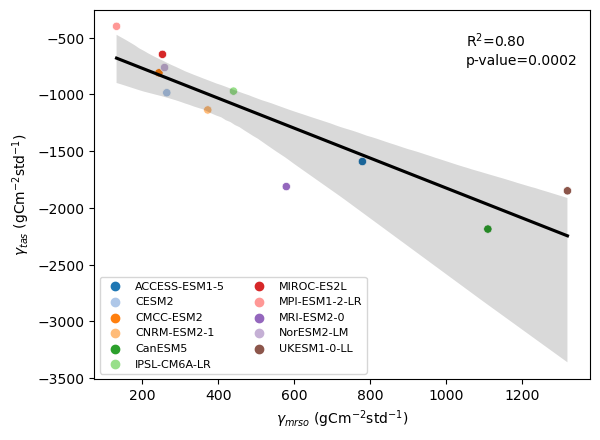

In [80]:
import seaborn as sns
from scipy import stats


fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot(x = "mrso_lt_std", y = "tas_lt_std", data=df_amz_lt_std, hue=df_amz_lt_std.index, palette="tab20")
ax = sns.regplot(x="mrso_lt_std", y = "tas_lt_std", data=df_amz_lt_std, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\gamma_{mrso}$ (gCm$^{-2}$std$^{-1}$)", ylabel= "$\gamma_{tas}$ (gCm$^{-2}$std$^{-1}$)")
ax.text(.75, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_amz_lt_std['mrso_lt_std'],df_amz_lt_std["tas_lt_std"]).rvalue**2),
    transform=ax.transAxes, fontsize = 10)
ax.text(.75, .85, 'p-value={:.4f}'.format(stats.linregress(df_amz_lt_std['mrso_lt_std'],df_amz_lt_std["tas_lt_std"]).pvalue),
    transform=ax.transAxes, fontsize = 10)

title= "model diversity - ssp585 " + "tas_lt_std"
# ax.set_title("Potential EC on tas")
ax.legend(loc='lower left', ncol=2, fontsize = 8)

title = "GAMMA_tas_mrso"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)  

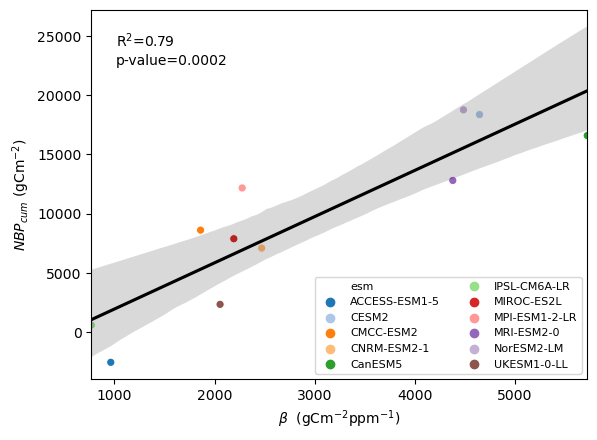

In [73]:
import seaborn as sns
from scipy import stats


fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot(x = "beta_ssp_lt_std", y = "nbp_tot", data=df_cum, hue=df_cum.index, palette="tab20")
ax = sns.regplot(x="beta_ssp_lt_std", y = "nbp_tot", data=df_cum, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\u03B2$  (gCm$^{-2}$ppm$^{-1}$)", ylabel= "$NBP_{cum}$ (gCm$^{-2}$)")
ax.text(.05, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_cum['beta_ssp_lt_std'],df_cum["nbp_tot"]).rvalue**2),
    transform=ax.transAxes, fontsize = 10)
ax.text(.05, .85, 'p-value={:.4f}'.format(stats.linregress(df_cum['beta_ssp_lt_std'],df_cum["nbp_tot"]).pvalue),
    transform=ax.transAxes, fontsize = 10)

title= "model diversity - ssp585 " + "nbp_tot"
# ax.set_title("Potential EC on tas")
ax.legend(loc='lower right', ncol=2, fontsize = 8)
# output_file = os.path.join(out_path, title) + ".png"

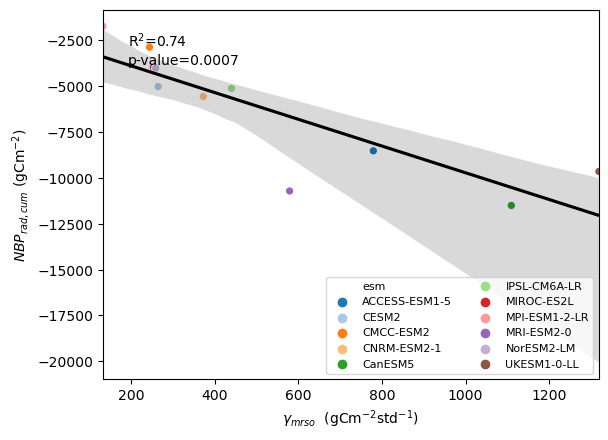

In [238]:
import seaborn as sns
from scipy import stats


fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot(x = "mrso_lt_std", y = "nbp_delta_rad", data=df_cum, hue=df_cum.index, palette="tab20")
ax = sns.regplot(x="mrso_lt_std", y = "nbp_delta_rad", data=df_cum, scatter=False, line_kws={"color": "black"})
ax.set(xlabel="$\gamma_{mrso}$  (gCm$^{-2}$std$^{-1}$)", ylabel= "$NBP_{rad, cum}$ (gCm$^{-2}$)")
ax.text(.05, .9, 'R$^2$={:.2f}'.format(stats.linregress(df_cum['mrso_lt_std'],df_cum["nbp_delta_rad"]).rvalue**2),
    transform=ax.transAxes, fontsize = 10)
ax.text(.05, .85, 'p-value={:.4f}'.format(stats.linregress(df_cum['mrso_lt_std'],df_cum["nbp_delta_rad"]).pvalue),
    transform=ax.transAxes, fontsize = 10)

title= "model diversity - ssp585 " + "nbp_delta_rad"
# ax.set_title("Potential EC on tas")
ax.legend(loc='lower right', ncol=2, fontsize = 8)
# output_file = os.path.join(out_path, title) + ".png"

### Scatterplot 1pctCO2&ssp585

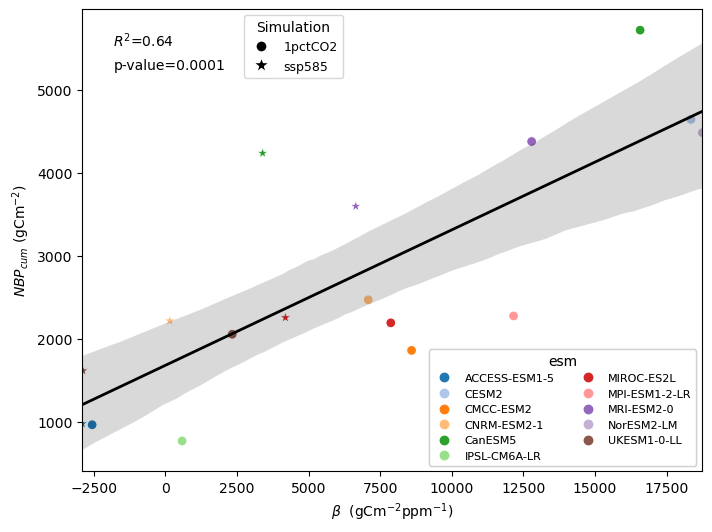

In [293]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

# Data preparation
mrso_data = final[["esm", "simulation", "nbp_tot"]]
tas_data = final[["esm", "simulation", "beta_ssp_lt_std"]]
merged_data = pd.merge(mrso_data,tas_data)
data_1pctCO2 = merged_data[merged_data['simulation'] == '1pctCO2']
data_ssp585 = merged_data[merged_data['simulation'] == 'ssp585']

# Color palette
palette = sns.color_palette("tab20", len(esm))
esm_color_map = dict(zip(esm, palette))


# Plot configuration
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots 
sns.scatterplot(
    data=data_1pctCO2, x="nbp_tot", y="beta_ssp_lt_std", hue="esm",
    marker="o", palette=esm_color_map, s=50, legend=False, ax=ax
)
sns.scatterplot(
    data=data_ssp585, x="nbp_tot", y="beta_ssp_lt_std", hue="esm",
    marker="*", palette=esm_color_map, s=80, legend=False, ax=ax
)

# Regression line
sns.regplot(
    data=merged_data, x="nbp_tot", y="beta_ssp_lt_std", scatter=False,
    line_kws={"color": "black", "linewidth": 2},  ax=ax
)

# Statistics
slope, intercept, r_value, p_value, std_err = linregress(merged_data['nbp_tot'], merged_data['beta_ssp_lt_std'])
ax.text(0.05, 0.92, r'$R^2$={:.2f}'.format(r_value**2), transform=ax.transAxes, fontsize=10)
ax.text(0.05, 0.87, 'p-value={:.4f}'.format(p_value), transform=ax.transAxes, fontsize=10)

# Legends
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='1pctCO2'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=12, label='ssp585')
]
esm_handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=6, label=esm) for esm, color in esm_color_map.items()]

simulation_legend = ax.legend(handles=handles, title="Simulation", loc="upper left", bbox_to_anchor=(0.25, 1), fontsize=9, title_fontsize=10)
esm_legend = ax.legend(handles=esm_handles, title="esm", loc="lower left", bbox_to_anchor=(0.55, 0.0), fontsize=8, title_fontsize=10, ncol = 2)
ax.add_artist(simulation_legend)
ax.add_artist(esm_legend)
ax.set(xlabel="$\u03B2$  (gCm$^{-2}$ppm$^{-1}$)", ylabel= "$NBP_{cum}$ (gCm$^{-2}$)")

plt.show()


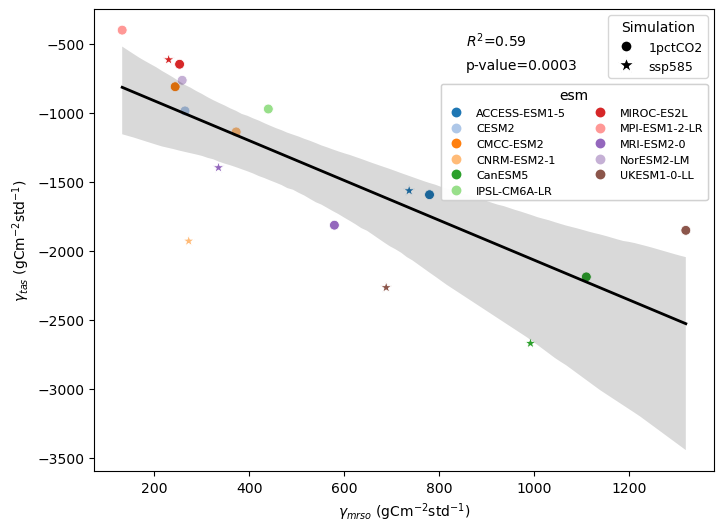

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

# Data preparation
mrso_data = final[["esm", "simulation", "mrso_lt_std"]]
tas_data = final[["esm", "simulation", "tas_lt_std"]]
merged_data = pd.merge(mrso_data,tas_data)
data_1pctCO2 = merged_data[merged_data['simulation'] == '1pctCO2']
data_ssp585 = merged_data[merged_data['simulation'] == 'ssp585']

# Color palette
palette = sns.color_palette("tab20", len(esm))
esm_color_map = dict(zip(esm, palette))


# Plot configuration
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots 
sns.scatterplot(
    data=data_1pctCO2, x="mrso_lt_std", y="tas_lt_std", hue="esm",
    marker="o", palette=esm_color_map, s=50, legend=False, ax=ax
)
sns.scatterplot(
    data=data_ssp585, x="mrso_lt_std", y="tas_lt_std", hue="esm",
    marker="*", palette=esm_color_map, s=80, legend=False, ax=ax
)

# Regression line
sns.regplot(
    data=merged_data, x="mrso_lt_std", y="tas_lt_std", scatter=False,
    line_kws={"color": "black", "linewidth": 2},  ax=ax
)

# Statistics
slope, intercept, r_value, p_value, std_err = linregress(merged_data['mrso_lt_std'], merged_data['tas_lt_std'])
ax.text(0.6, 0.92, r'$R^2$={:.2f}'.format(r_value**2), transform=ax.transAxes, fontsize=10)
ax.text(0.6, 0.87, 'p-value={:.4f}'.format(p_value), transform=ax.transAxes, fontsize=10)

# Legends
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='1pctCO2'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=12, label='ssp585')
]
esm_handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=6, label=esm) for esm, color in esm_color_map.items()]

simulation_legend = ax.legend(handles=handles, title="Simulation", loc="upper right", fontsize=9, title_fontsize=10)
esm_legend = ax.legend(handles=esm_handles, title="esm", loc="upper left", bbox_to_anchor=(0.55, 0.85), fontsize=8, title_fontsize=10, ncol = 2)
ax.add_artist(simulation_legend)
ax.add_artist(esm_legend)

plt.xlabel(r"$\gamma_{mrso}$ (gCm$^{-2}$std$^{-1}$)")
plt.ylabel(r"$\gamma_{tas}$ (gCm$^{-2}$std$^{-1}$)")
plt.show()

title = "GAMMA_tas_mrso_1pctCO2_ssp585"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)  

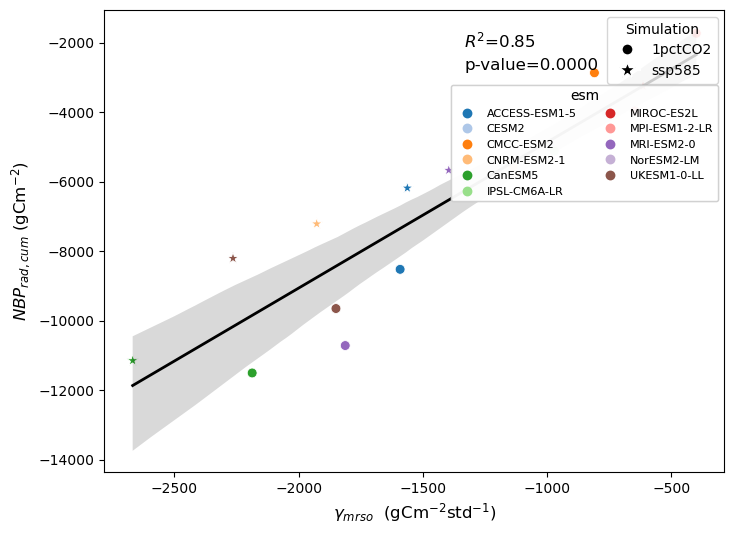

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import linregress

# Data preparation
mrso_data = final[["esm", "simulation", "mrso_lt_std", "nbp_delta_rad"]]
tas_data = final[["esm", "simulation", "tas_lt_std", "nbp_delta_rad"]]
merged_data = pd.merge(mrso_data,tas_data)
data_1pctCO2 = merged_data[merged_data['simulation'] == '1pctCO2']
data_ssp585 = merged_data[merged_data['simulation'] == 'ssp585']

# Color palette
palette = sns.color_palette("tab20", len(esm))
esm_color_map = dict(zip(esm, palette))


# Plot configuration
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots 
sns.scatterplot(
    data=data_1pctCO2, x="tas_lt_std", y="nbp_delta_rad", hue="esm",
    marker="o", palette=esm_color_map, s=50, legend=False, ax=ax
)
sns.scatterplot(
    data=data_ssp585, x="tas_lt_std", y="nbp_delta_rad", hue="esm",
    marker="*", palette=esm_color_map, s=80, legend=False, ax=ax
)

# Regression line
sns.regplot(
    data=merged_data, x="tas_lt_std", y="nbp_delta_rad", scatter=False,
    line_kws={"color": "black", "linewidth": 2},  ax=ax
)

# Statistics
slope, intercept, r_value, p_value, std_err = linregress(merged_data['tas_lt_std'], merged_data['nbp_delta_rad'])
ax.text(0.58, 0.92, r'$R^2$={:.2f}'.format(r_value**2), transform=ax.transAxes, fontsize=12)
ax.text(0.58, 0.87, 'p-value={:.4f}'.format(p_value), transform=ax.transAxes, fontsize=12)

# Legends
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='1pctCO2'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=12, label='ssp585')
]
esm_handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=6, label=esm) for esm, color in esm_color_map.items()]

simulation_legend = ax.legend(handles=handles, title="Simulation", loc="upper right", fontsize=10, title_fontsize=10)
esm_legend = ax.legend(handles=esm_handles, title="esm", loc="upper left", bbox_to_anchor=(0.55, 0.85), fontsize=8, title_fontsize=10, ncol = 2)
ax.add_artist(simulation_legend)
ax.add_artist(esm_legend)

ax.set_xlabel(xlabel="$\gamma_{mrso}$  (gCm$^{-2}$std$^{-1}$)", fontsize = 12)
ax.set_ylabel(ylabel= "$NBP_{rad, cum}$ (gCm$^{-2}$)", fontsize = 12)
plt.show()


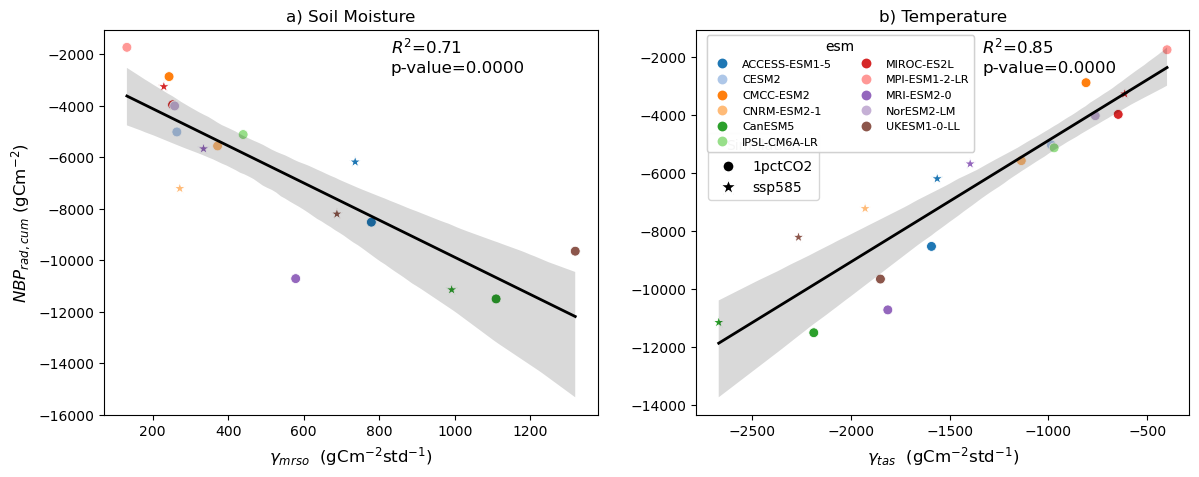

In [82]:
import seaborn as sns
from scipy.stats import linregress

# Data preparation
mrso_data = final[["esm", "simulation", "mrso_lt_std", "nbp_delta_rad"]]
tas_data = final[["esm", "simulation", "tas_lt_std", "nbp_delta_rad"]]
merged_data = pd.merge(mrso_data,tas_data)
data_1pctCO2 = merged_data[merged_data['simulation'] == '1pctCO2']
data_ssp585 = merged_data[merged_data['simulation'] == 'ssp585']

# Color palette
palette = sns.color_palette("tab20", len(esm))
esm_color_map = dict(zip(esm, palette))


# Plot configuration
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes.flatten()[0]  
# Scatter plots 
sns.scatterplot(
    data=data_1pctCO2, x="mrso_lt_std", y="nbp_delta_rad", hue="esm",
    marker="o", palette=esm_color_map, s=50, legend=False, ax=ax
)
sns.scatterplot(
    data=data_ssp585, x="mrso_lt_std", y="nbp_delta_rad", hue="esm",
    marker="*", palette=esm_color_map, s=80, legend=False, ax=ax
)

# Regression line
sns.regplot(
    data=merged_data, x="mrso_lt_std", y="nbp_delta_rad", scatter=False,
    line_kws={"color": "black", "linewidth": 2},  ax=ax
)

# Statistics
slope, intercept, r_value, p_value, std_err = linregress(merged_data['mrso_lt_std'], merged_data['nbp_delta_rad'])
ax.text(0.58, 0.94, r'$R^2$={:.2f}'.format(r_value**2), transform=ax.transAxes, fontsize=12)
ax.text(0.58, 0.89, 'p-value={:.4f}'.format(p_value), transform=ax.transAxes, fontsize=12)

# Legends
# handles = [
#     plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='1pctCO2'),
#     plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=12, label='ssp585')
# ]
# esm_handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=6, label=esm) for esm, color in esm_color_map.items()]

# simulation_legend = ax.legend(handles=handles, title="Simulation", loc="upper right", fontsize=10, title_fontsize=10)
# esm_legend = ax.legend(handles=esm_handles, title="esm", loc="upper left", bbox_to_anchor=(0.55, 0.85), fontsize=8, title_fontsize=10, ncol = 2)
# ax.add_artist(simulation_legend)
# ax.add_artist(esm_legend)
ax.set_xlabel(xlabel="$\gamma_{mrso}$  (gCm$^{-2}$std$^{-1}$)", fontsize = 12)
ax.set_ylabel(ylabel= "$NBP_{rad, cum}$ (gCm$^{-2}$)", fontsize = 12)
ax.set_title("a) Soil Moisture")

ax = axes.flatten()[1]
# Scatter plots 
sns.scatterplot(
    data=data_1pctCO2, x="tas_lt_std", y="nbp_delta_rad", hue="esm",
    marker="o", palette=esm_color_map, s=50, legend=False, ax=ax
)
sns.scatterplot(
    data=data_ssp585, x="tas_lt_std", y="nbp_delta_rad", hue="esm",
    marker="*", palette=esm_color_map, s=80, legend=False, ax=ax
)

# Regression line
sns.regplot(
    data=merged_data, x="tas_lt_std", y="nbp_delta_rad", scatter=False,
    line_kws={"color": "black", "linewidth": 2},  ax=ax
)

# Statistics
slope, intercept, r_value, p_value, std_err = linregress(merged_data['tas_lt_std'], merged_data['nbp_delta_rad'])
ax.text(0.58, 0.94, r'$R^2$={:.2f}'.format(r_value**2), transform=ax.transAxes, fontsize=12)
ax.text(0.58, 0.89, 'p-value={:.4f}'.format(p_value), transform=ax.transAxes, fontsize=12)

# Legends
handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='1pctCO2'),
    plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='black', markersize=12, label='ssp585')
]
esm_handles = [plt.Line2D([0], [0], marker='o', color=color, linestyle='', markersize=6, label=esm) for esm, color in esm_color_map.items()]

simulation_legend = ax.legend(handles=handles, title="Simulation", loc="upper left", bbox_to_anchor=(0.01, 0.75), fontsize=10, title_fontsize=10)
esm_legend = ax.legend(handles=esm_handles, title="esm", loc="upper left", bbox_to_anchor=(0.01, 1), fontsize=8, title_fontsize=10, ncol = 2)
ax.add_artist(simulation_legend)
ax.add_artist(esm_legend)
ax.set_xlabel(xlabel="$\gamma_{tas}$  (gCm$^{-2}$std$^{-1}$)", fontsize = 12)
ax.set_ylabel(ylabel= "", fontsize = 12)
ax.set_title("b) Temperature")

plt.show()
title = "NBPrad_tas_mrso"
fig.savefig(os.path.join(out_path, title + ".png"), bbox_inches='tight', dpi = 400)
fig.savefig(os.path.join(out_path, title + ".pdf"), bbox_inches='tight', dpi = 400)  

# Part2: IAV ssp585 contribution

The relationship between NEP and CO2 is logarithimic, but if we consider the range of CO2 ppm of historical (280-400) and ssp585 (400-1135) separately, it is linear.\
For historical, the period is from 1850-01 to 1885-12 (36 yrs). \
For ssp585, the period is from 1886-01-01 to 1989-01-01 (104 yrs).

We calculate the IAV of $GPP$, %Ra%, %Rh% and $NBP$ from the ssp585 simulation as:

\begin{equation}
NEP_{iav} = a0 + sT * T_{iav} + smrso * mrso_{iav} + sSW_{in} * SW_{in, iav} + + sN34 * N34_{iav} + \epsilon
\end{equation}

We estimate the coefficients $sT$, $smrso$, $sSW_{in}$ and $sN34$, representing the contribution of the sensitivity of carbon fluxes to iav of variables

In [ ]:
from sklearn import metrics

# SSP585
ds_ssp_pred = {}
ds_r2 = {}
ds_rmse = {}

for i, k in enumerate(ds_ssp_nbp.keys()):
        print("processing ssp585_" + k)

        Y = ds_ssp_nbp[k].cumsum(dim = "time"); Y - Y.isel(time = 0)
        Xco2 = (ds_ssp_co2[k] - ds_ssp_co2[k].isel(time = 0))
        X2ssp = (ds_ssp_tas[k] - ds_ssp_tas[k].isel(time = 0))
        X3ssp = (ds_ssp_mrso[k] - ds_ssp_mrso[k].isel(time = 0))
        X4ssp = (ds_ssp_rsds[k] - ds_ssp_rsds[k].isel(time = 0))
        X5ssp = (ds_ssp_vpd[k] - ds_ssp_vpd[k].isel(time = 0))
        X6ssp = (ds_ssp_pr[k] - ds_ssp_pr[k].isel(time = 0))

        # Reshape variables
        Y = Y.sel(lon= slice(260,340)).fillna(0.001)
        Xco2 = Xco2.rename("co2").sel(lon= slice(260,340))
        X2ssp = X2ssp.rename("tas").sel(lon= slice(260,340))
        X3ssp = X3ssp.rename("mrso").fillna(0.001).sel(lon= slice(260,340))
        X4ssp = X4ssp.rename("rsds").sel(lon= slice(260,340))
        X5ssp = X5ssp.rename("vpd").sel(lon= slice(260,340))
        X6ssp = X6ssp.rename("pr").sel(lon= slice(260,340))

        coef_beta_nbp = beta_nbp[i]["slope"]
        coef_gamma_nbp_tas = gamma_tas_nbp[i]["slope"]
        coef_gamma_nbp_mrso = gamma_mrso_nbp[i]["slope"]
        coef_gamma_nbp_rsds = gamma_rsds_nbp[i]["slope"]
        coef_gamma_nbp_vpd = gamma_vpd_nbp[i]["slope"]
        coef_gamma_nbp_pr = gamma_pr_nbp[i]["slope"]

        # # Create empty datarray to store R2 and Y predicted 
        # r_squared = xr.DataArray(data=None, coords=[X2ssp.cell], dims=["cell"])
        # pred = xr.DataArray(data=None, coords=[Y.lat, Y.lon, Y.time], dims=["lat", "lon", "time"])
        # pred = xr.DataArray(data=None, coords=[Y.lat, Y.lon, Y.time], dims=["lat", "lon", "time"])

        pred = ((coef_beta_nbp*Xco2) + (coef_gamma_nbp_tas*X2ssp) + (coef_gamma_nbp_mrso*X3ssp))# + (coef_gamma_nbp_rsds*X4ssp)) # + (coef_gamma_nbp_pr*X6ssp))
        rss = ((Y - pred)**2).sum(dim = "time")
        tss = ((Y - Y.mean(dim = "time"))**2).sum(dim = "time")
        r_squared = 1 - (rss/tss)
        rmse = np.sqrt(rss/Y.time.shape[0])

        ds_ssp_pred[k] = pred.astype(np.float32)
        ds_r2[k] = r_squared.astype(np.float32)
        ds_rmse[k] = rmse.astype(np.float32)
        



processing ssp585_ACCESS-ESM1-5
processing ssp585_CESM2
processing ssp585_CMCC-ESM2
processing ssp585_CNRM-ESM2-1
processing ssp585_CanESM5
processing ssp585_IPSL-CM6A-LR
processing ssp585_MIROC-ES2L
processing ssp585_MPI-ESM1-2-LR
processing ssp585_MRI-ESM2-0
processing ssp585_NorESM2-LM
processing ssp585_UKESM1-0-LL


In [ ]:
from sklearn import linear_model
from regressors import stats   

# Define regression technique
# Ridge Regression with Cross-Validation
alphas = np.linspace(.000001, 1)
alphas = np.logspace(-6, 2, 10)
ridge = linear_model.RidgeCV(alphas = alphas, cv =5)

# Ridge Regression without Cross-Validation
# ridge = linear_model.Ridge()

# SSP585
coef_ridge_ssp = []
r2_ridge_ssp = []
pred_ridge_ssp = []
pval_ridge_ssp = []
for i, k in enumerate(ds_ssp_nbp.keys()):
    print("processing ssp585_" + k)

    Y = ds_ssp_nbp[k].cumsum(dim = "time")

    # Reshape variables
    Y = Y.sel(lon= slice(260,340)).fillna(0.001)
    Xco2 = (ds_ssp_co2[k]).rename("co2").sel(lon= slice(260,340))
    X1ssp = ds_ssp_tas[k].rename("tas").sel(lon= slice(260,340))
    X2ssp = ds_ssp_pr[k].rename("pr").sel(lon= slice(260,340))
    X3ssp = ds_ssp_mrso[k].rename("mrso").fillna(0.001).sel(lon= slice(260,340))
    X4ssp = ds_ssp_rsds[k].rename("rsds").sel(lon= slice(260,340))
    X5ssp = ds_ssp_vpd[k].rename("vpd").sel(lon= slice(260,340))

    # BETA from 1pctCO2-bgc
    coef_beta_nbp = beta_nbp[i]["slope"]
    # Mean climate in ssp585
    X1ssp = X1ssp.mean(dim = "time")
    X2ssp = X2ssp.mean(dim = "time")
    X3ssp = xr.where((X3ssp.mean(dim = "time").fillna(0.001) == np.inf, 0.001, X3ssp.mean(dim = "time").fillna(0.001))).fillna(0.001)     # sometimes it could happen to have Inf values
    X4ssp = X4ssp.mean(dim = "time")
    X5ssp = X5ssp.mean(dim = "time")

    # Stack on 1D vector
    coef_beta_nbp = coef_beta_nbp.stack(cell = ["lon", "lat"])
    Xco2 = Xco2.stack(cell = ["lon", "lat"])
    X1ssp = X1ssp.stack(cell = ["lon","lat"])
    X2ssp = X2ssp.stack(cell = ["lon","lat"])
    X3ssp = X3ssp.stack(cell = ["lon","lat"])
    X4ssp = X4ssp.stack(cell = ["lon","lat"])
    X5ssp = X5ssp.stack(cell = ["lon","lat"])
    Y = Y.stack(cell = ["lon","lat"])

    # 
    X1ssp = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time","cell"])
    for c in Xenso.cell:
        locator = {'cell':c}
        Xenso.loc[locator] = ensossp.values
        Xenso.values = Xenso.values.astype("float64")       # To avoid the resulting values are "object" rather than "float64" 
    Xenso = Xenso.rename("sst")

    # Create empty dataarray to store regression coefficients
    coef = xr.DataArray(data=None, coords=[X1ssp.time,X1ssp.cell], dims=["time","cell"])
    coef["tas"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    # coef["pr"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    coef["mrso"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    coef["rsds"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    coef["co2"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])

    # Create empty dataarray to store p-values
    pval = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    pval["tas"] = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    # pval["pr"] = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    pval["mrso"] = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    pval["rsds"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    pval["co2"] =  xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])

    # Create empty datarray to store R2 and Y predicted 
    r_squared = xr.DataArray(data=None, coords=[X1ssp.cell], dims=["cell"])
    pred = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time","cell"])
    pred["nbp"] = xr.DataArray(data=None, coords=[Y.time, Y.cell], dims=["time", "cell"])

    for c in X1ssp.cell:
        locator = {'cell':c}
        # Check if the mrso value is NaN or 0 for this cell
        if np.isnan(ds_ssp_mrso[k].stack(cell = ["lon","lat"]).loc[locator].values).any() or (ds_ssp_mrso[k].stack(cell = ["lon","lat"]).loc[locator].values == 0).any():

            # Assign NaN to all result arrays for this cell
            coef["tas"].loc[locator] = np.nan
            coef["mrso"].loc[locator] = np.nan
            coef["rsds"].loc[locator] = np.nan
            coef["vpd"].loc[locator] = np.nan

            pval["tas"].loc[locator] = np.nan
            pval["mrso"].loc[locator] = np.nan
            pval["rsds"].loc[locator] = np.nan
            pval["vpd"].loc[locator] = np.nan

            r_squared.loc[locator] = np.nan
            pred["nep"].loc[locator] = np.nan
            continue  # Skip this cell and move to the next

        # merge predictors in one dataarray
        df = np.array(((coef_beta_nbp.loc[locator]*Xco2.loc[locator]), X1ssp.loc[locator].values, X3ssp.loc[locator].values, X4ssp.loc[locator].values)); df = df.T
        model = ridge.fit(df,Y.loc[locator].values)
        r2 = ridge.score(df,Y.loc[locator])
        ypred = ridge.predict(df)

        # coef["pr"].loc[locator] = model.coef_[0]
        coef["co2"].loc[locator] = model.coef_[0] 
        coef["tas"].loc[locator] = model.coef_[1] 
        coef["mrso"].loc[locator] = model.coef_[2]
        coef["rsds"].loc[locator] = model.coef_[3] 

        # p-value of the index "0" refers to the intercept
        # pval["pr"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[1]
        pval["co2"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[1]
        pval["tas"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[2]
        pval["mrso"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[3]
        pval["rsds"].loc[locator] = stats.coef_pval(model,df,Y.loc[locator].values)[4]
        
        r_squared.loc[locator] = r2
        pred["nep"].loc[locator] = ypred

    coef = coef.unstack()
    coef = xr.concat([coef.co2, coef.tas, coef.mrso, coef.rsds], dim = "coefficients")
    coef["co2"] = coef.co2.astype(np.float64)
    coef["tas"] = coef.tas.astype(np.float64)
    coef["mrso"] = coef.mrso.astype(np.float64)
    coef["rsds"] = coef.rsds.astype(np.float64)
    # coef["vpd"] = coef.vpd.astype(np.float64)

    pval = pval.unstack()
    pval = xr.concat([pval.co2, pval.tas, pval.mrso, pval.rsds], dim = "p-values")
    pval["co2"] = pval.co2.astype(np.float64)
    pval["tas"] = pval.tas.astype(np.float64)
    pval["mrso"] = pval.mrso.astype(np.float64)
    pval["rsds"] = pval.rsds.astype(np.float64)
    # pval["vpd"] = pval.vpd.astype(np.float64)
    # pval["sst"] = pval.sst.astype(np.float64)
    
    r_squared = r_squared.astype(np.float64).unstack()
    pred = pred.astype(np.float64).unstack()

    coef_ridge_ssp.append(coef)
    r2_ridge_ssp.append(r_squared)
    pred_ridge_ssp.append(pred)
    pval_ridge_ssp.append(pval)


# Save and export regression list data
import pickle
data_path = 'G:/My Drive/Amazon_CMIP6/results/'

with open(os.path.join(data_path+"gamma_iav_nep_hist_coef_std"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge_hist, fp)
with open(os.path.join(data_path+"gamma_iav_nep_ssp_coef_std"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge_ssp, fp)

with open(os.path.join(data_path+"gamma_iav_nep_hist_pval"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge_hist, fp)
with open(os.path.join(data_path+"gamma_iav_nep_ssp_pval"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge_ssp, fp)

with open(os.path.join(data_path+"gamma_iav_nep_hist_r2"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge_hist, fp)
with open(os.path.join(data_path+"gamma_iav_nep_ssp_r2"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge_ssp, fp)

with open(os.path.join(data_path+"gamma_iav_nep_hist_ypred"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge_hist, fp)
with open(os.path.join(data_path+"gamma_iav_nep_ssp_ypred"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge_ssp, fp)



In [ ]:
df_amz = pd.DataFrame()
for k in ds_ssp_nbp.keys():    # rr = files_list[k].parent_variant_label
    print(k)
    content = zonal_stat(ds_ssp_pred[k], geodf).sel(region = 1).to_dataframe(name = "nbp_pred").drop(columns = ["region"]).rename(columns = {"nbp_pred":"nbp_pred " + k}) # + " " + rr
    content1 = zonal_stat(ds_ssp_nbp[k].cumsum(dim = "time"), geodf).sel(region = 1).to_dataframe(name = "nbp").drop(columns = ["region"]).rename(columns = {"nbp":"nbp " + k}) # + " " + rr

    df_amz = pd.concat([df_amz, content, content1], axis = 1)

df_amz = df_amz.drop(columns = "height")
df_amz = df_amz.cumsum()
df_amz

ACCESS-ESM1-5
CESM2
CMCC-ESM2
CNRM-ESM2-1
CanESM5
IPSL-CM6A-LR
MIROC-ES2L
MPI-ESM1-2-LR
MRI-ESM2-0
NorESM2-LM
UKESM1-0-LL


,nbp_pred ACCESS-ESM1-5,nbp ACCESS-ESM1-5,nbp_pred CESM2,nbp CESM2,nbp_pred CMCC-ESM2,nbp CMCC-ESM2,nbp_pred CNRM-ESM2-1,nbp CNRM-ESM2-1,nbp_pred CanESM5,nbp CanESM5,...,nbp_pred MIROC-ES2L,nbp MIROC-ES2L,nbp_pred MPI-ESM1-2-LR,nbp MPI-ESM1-2-LR,nbp_pred MRI-ESM2-0,nbp MRI-ESM2-0,nbp_pred NorESM2-LM,nbp NorESM2-LM,nbp_pred UKESM1-0-LL,nbp UKESM1-0-LL
time,,,,,,,,,,,,,,,,,,,,,
2015-12-31,0.000000,18.675913,0.000000,25.571261,0.000000,82.678341,0.000000,21.454181,0.000000,8.234187,...,0.000000,-8.690239,0.000000,68.459859,0.000000,-103.397069,0.000000,29.030805,0.000000,-7.217450
2016-12-31,114.353008,40.575867,507.880826,121.946391,-497.766002,225.686035,-896.579344,-4.398739,-442.464120,-2.582372,...,418.797651,-1.214233,-124.161960,144.108964,-764.035302,-346.240031,679.000575,157.471533,-320.305904,-27.659702
2017-12-31,106.604455,59.058600,952.958023,271.100967,-1377.441496,406.713718,-1455.879983,-8.725580,-346.262014,-21.764681,...,1201.709901,35.638958,-445.084264,196.755108,2037.588290,-473.674198,1291.702770,361.869104,647.415942,-12.452089
2018-12-31,-180.183314,66.427658,1906.531743,502.143194,-3115.176848,605.319527,-2351.275762,-41.784187,-1209.463660,-71.300240,...,1439.021395,99.081560,-763.130547,271.430711,3958.991206,-514.025207,1667.929432,623.170156,-98.880369,-24.838828
2019-12-31,-1110.841482,40.081331,2238.685196,783.669287,-4422.390677,890.189202,-2703.344791,-34.529305,-1210.629897,-148.198558,...,1577.352201,163.023336,-908.670694,372.820353,5758.771196,-443.076023,1562.967415,915.695087,-457.387892,-46.506093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2096-12-31,-264589.790632,-75334.880871,431713.389080,356974.801900,2330.303509,237139.076281,68572.940072,42355.289498,217354.931769,26496.622560,...,168337.331974,136312.954942,196235.434719,150526.575980,305859.240163,179050.588484,448812.624328,381795.643542,-225997.623964,-67654.975552
2097-12-31,-270435.016690,-78173.597187,446400.739578,367847.287748,5047.088986,243063.319933,72392.922292,42495.892706,228343.002882,29005.908009,...,174320.732124,140417.838446,203302.335240,154192.895855,316358.418726,185090.490943,464474.711282,393372.410129,-229145.287668,-70262.726849
2098-12-31,-277189.305610,-81109.688250,461859.357405,378909.929961,8292.375903,249057.002229,76708.764629,42602.286733,239873.360836,31596.067178,...,180528.458191,144576.292513,210757.831768,157939.645986,327213.908235,191313.929131,480331.538783,405188.642062,-233260.110470,-72979.624316


Text(0, 0.5, 'NBP (gCm$^{-2}$)')

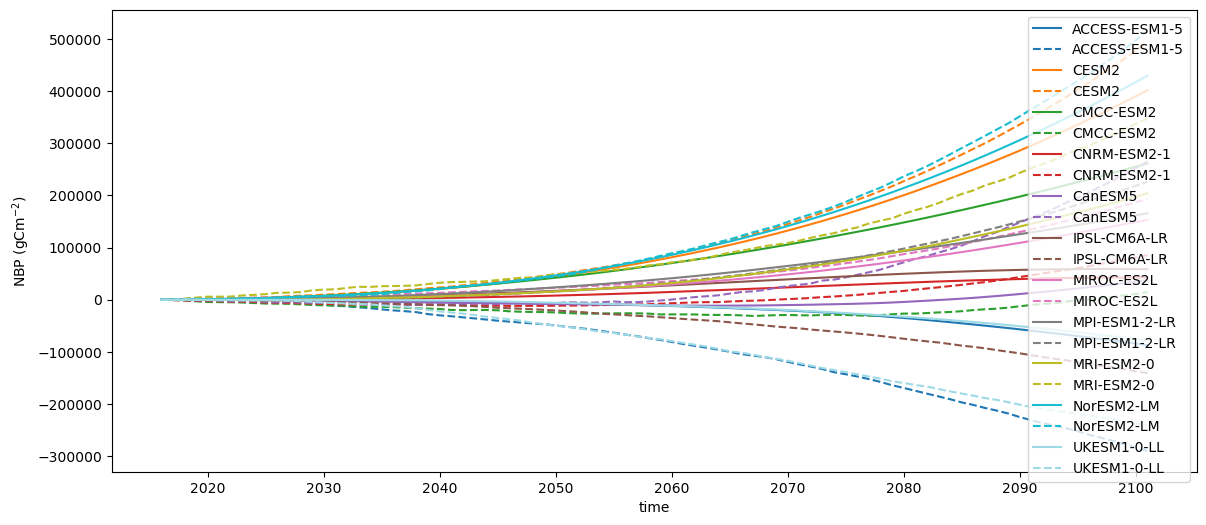

In [ ]:
fig = plt.figure(figsize=(14, 6))

cmap = plt.cm.get_cmap('tab20', len(esm))
colors = [cmap(i) for i in range(len(esm))]

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(111)
for m, mm in enumerate(esm):
    ax0.plot(df_amz.index, df_amz['nbp ' + mm], label=mm, color = colors[m])  # Line plot for NEP
    ax0.plot(df_amz.index, df_amz['nbp_pred ' + mm], linestyle = "dashed", label=mm, color = colors[m])  # Line plot for NEP

# Set labels and title
ax0.legend()
ax0.set_xlabel("time")
ax0.set_ylabel("NBP (gCm$^{-2}$)")
# ax0.set_ylim(-80, 1400)

Plot predicted NEP vs original NEP

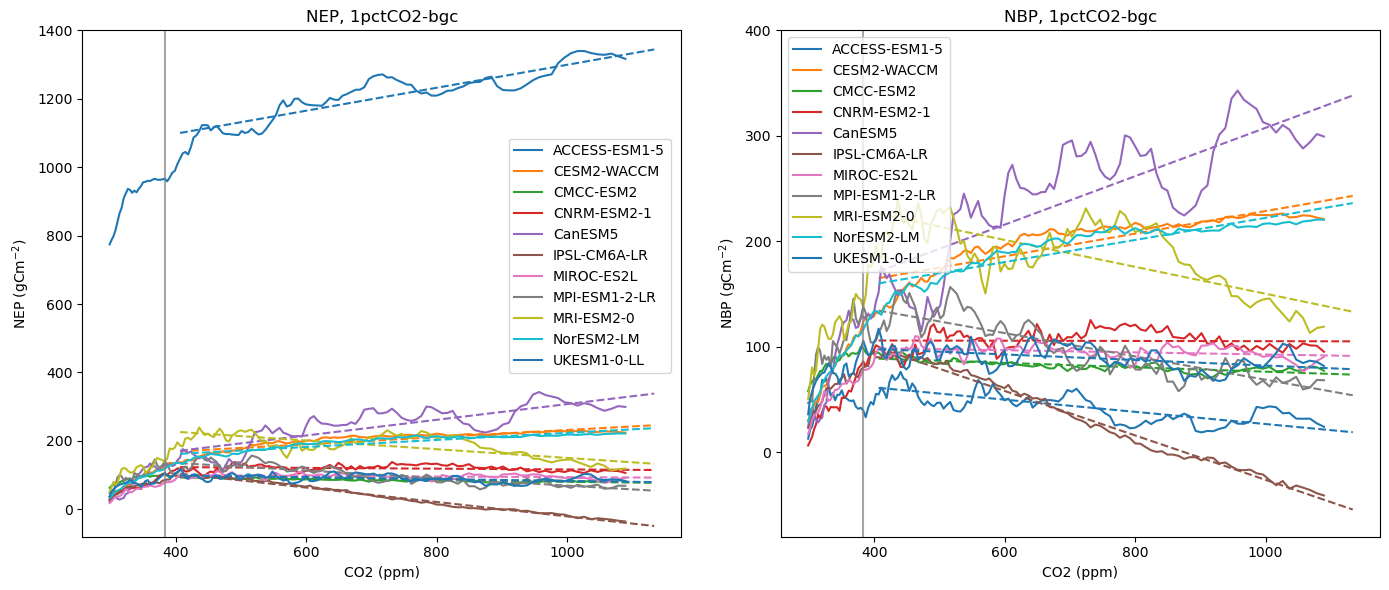

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig = plt.figure(figsize=(14, 6))

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
for m, mm in enumerate(models):
    # Plot the first line
    line1, = ax0.plot(df_amz["ppm"], df_amz[f'nep {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax0.plot(df_amz["ppm"], df_amz[f'nep_pred {mm}'], linestyle='--', color=line1.get_color(), label='_nolegend_')# Set labels and title

ax0.set_xlabel("CO2 (ppm)")
ax0.set_ylabel("NEP (gCm$^{-2}$)")
ax0.set_ylim(-80, 1400)

# Highlight a specific CO2 value with a vertical line
ax0.axvline(df_amz.iloc[30]["ppm"], color="grey", alpha=0.7)

# Add legend and title
ax0.legend(models, loc='upper left', bbox_to_anchor = [0.7, 0.8])
ax0.set_title("NEP, 1pctCO2-bgc")

# Second plot for NBP
ax1 = fig.add_subplot(122)
for m, mm in enumerate(models):
    # Plot the first line
    line1, = ax1.plot(df_amz["ppm"], df_amz[f'nbp {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax1.plot(df_amz["ppm"], df_amz[f'nbp_pred {mm}'], linestyle='--', color=line1.get_color(), label='_nolegend_')# Set labels and title
        
# Set labels and title
ax1.set_xlabel("CO2 (ppm)")
ax1.set_ylabel("NBP (gCm$^{-2}$)")
ax1.set_ylim(-80, 400)

# Highlight a specific CO2 value with a vertical line
ax1.axvline(df_amz.iloc[30]["ppm"], color="grey", alpha=0.7)

# Add legend and title
ax1.legend(models, loc = "upper left")
ax1.set_title("NBP, 1pctCO2-bgc")

plt.tight_layout()
plt.show()


### Remove the eCO2 effect estimated from 1pctCo2-bgc simulations from NEP and NBP in ssp585

In [ ]:
# Interpolate co2 to have 86 years as ssp585

x_old = np.linspace(1, ds_co2_amz.to_dataframe().drop(columns = ["region"]).shape[0], ds_co2_amz.to_dataframe().drop(columns = ["region"]).shape[0])
x_new = np.linspace(1, len(df_amz_ssp.index), len(df_amz_ssp.index))

# Create an empty DataFrame to store interpolated values
df_amz_ssp_eCO2 = pd.DataFrame(index=df_amz_ssp[:86].index)

# Interpolate the values of CO2 and predict the NEP_eCO2 
for column in df_amz_ssp.columns:
    X = np.interp(x_new, x_old, ds_co2_amz.to_dataframe().drop(columns = ["region"]).ppm.values)
    if "nep" in column:
        a = coef_ssp_nep[coef_ssp_nep.index.to_series().apply(lambda idx: idx in column)].iloc[0].values
    if "nbp" in column: 
        a = coef_ssp_nbp[coef_ssp_nbp.index.to_series().apply(lambda idx: idx in column)].iloc[0].values
    df_amz_ssp_eCO2[column] = a * X
    
df_amz_ssp_eCO2.head(10)

,nep ACCESS-ESM1-5,nbp ACCESS-ESM1-5,nep CESM2-WACCM,nbp CESM2-WACCM,nep CMCC-ESM2,nbp CMCC-ESM2,nep CNRM-ESM2-1,nbp CNRM-ESM2-1,nep CanESM5,nbp CanESM5,...,nep MIROC-ES2L,nbp MIROC-ES2L,nep MPI-ESM1-2-LR,nbp MPI-ESM1-2-LR,nep MRI-ESM2-0,nbp MRI-ESM2-0,nep NorESM2-LM,nbp NorESM2-LM,nep UKESM1-0-LL,nbp UKESM1-0-LL
time,,,,,,,,,,,,,,,,,,,,,
2015-12-31 00:00:00,95.426688,-16.444708,29.796413,30.486959,-6.061882,-5.919501,-3.244454,-0.310313,65.226171,65.224407,...,-2.666362,-2.849700,-31.405006,-31.409082,-36.256765,-36.256765,29.383997,29.769517,-7.494745,-7.457449
2016-12-31 00:00:00,96.379881,-16.608970,30.094042,30.791486,-6.122433,-5.978629,-3.276862,-0.313413,65.877698,65.875917,...,-2.692996,-2.878165,-31.718702,-31.722819,-36.618925,-36.618925,29.677506,30.066877,-7.569608,-7.531940
2017-12-31 00:00:00,97.343143,-16.774968,30.394814,31.099229,-6.183623,-6.038382,-3.309612,-0.316546,66.536108,66.534309,...,-2.719911,-2.906930,-32.035712,-32.039870,-36.984910,-36.984910,29.974116,30.367378,-7.645262,-7.607217
2018-12-31 00:00:00,98.316473,-16.942700,30.698731,31.410189,-6.245453,-6.098760,-3.342705,-0.319711,67.201401,67.199583,...,-2.747107,-2.935996,-32.356036,-32.360236,-37.354721,-37.354721,30.273826,30.671020,-7.721707,-7.683281
2019-12-31 00:00:00,99.299873,-17.112167,31.005792,31.724366,-6.307922,-6.159762,-3.376140,-0.322909,67.873575,67.871740,...,-2.774585,-2.965363,-32.679674,-32.683916,-37.728357,-37.728357,30.576637,30.977804,-7.798942,-7.760132
2020-12-31 00:00:00,100.293342,-17.283370,31.315996,32.041760,-6.371031,-6.221389,-3.409917,-0.326139,68.552632,68.550778,...,-2.802344,-2.995031,-33.006626,-33.010909,-38.105819,-38.105819,30.882548,31.287729,-7.876968,-7.837771
2021-12-31 00:00:00,101.296879,-17.456308,31.629345,32.362371,-6.434780,-6.283640,-3.444037,-0.329402,69.238571,69.236699,...,-2.830384,-3.024999,-33.336891,-33.341217,-38.487107,-38.487107,31.191560,31.600794,-7.955786,-7.916195
2022-12-31 00:00:00,102.310486,-17.630981,31.945838,32.686198,-6.499168,-6.346516,-3.478499,-0.332699,69.931393,69.929502,...,-2.858705,-3.055268,-33.670469,-33.674839,-38.872221,-38.872221,31.503671,31.917001,-8.035393,-7.995407
2023-12-31 00:00:00,103.330805,-17.806811,32.264426,33.012170,-6.563983,-6.409808,-3.513189,-0.336016,70.628803,70.626893,...,-2.887215,-3.085738,-34.006257,-34.010671,-39.259884,-39.259884,31.817850,32.235302,-8.115529,-8.075144


In [ ]:
df_amz_ssp_net = pd.DataFrame()
for column in df_amz_ssp.columns:
    df_amz_ssp_net[column] = df_amz_ssp[column].values - df_amz_ssp_eCO2[column].values
    
df_amz_ssp_net.index = df_amz_ssp.index

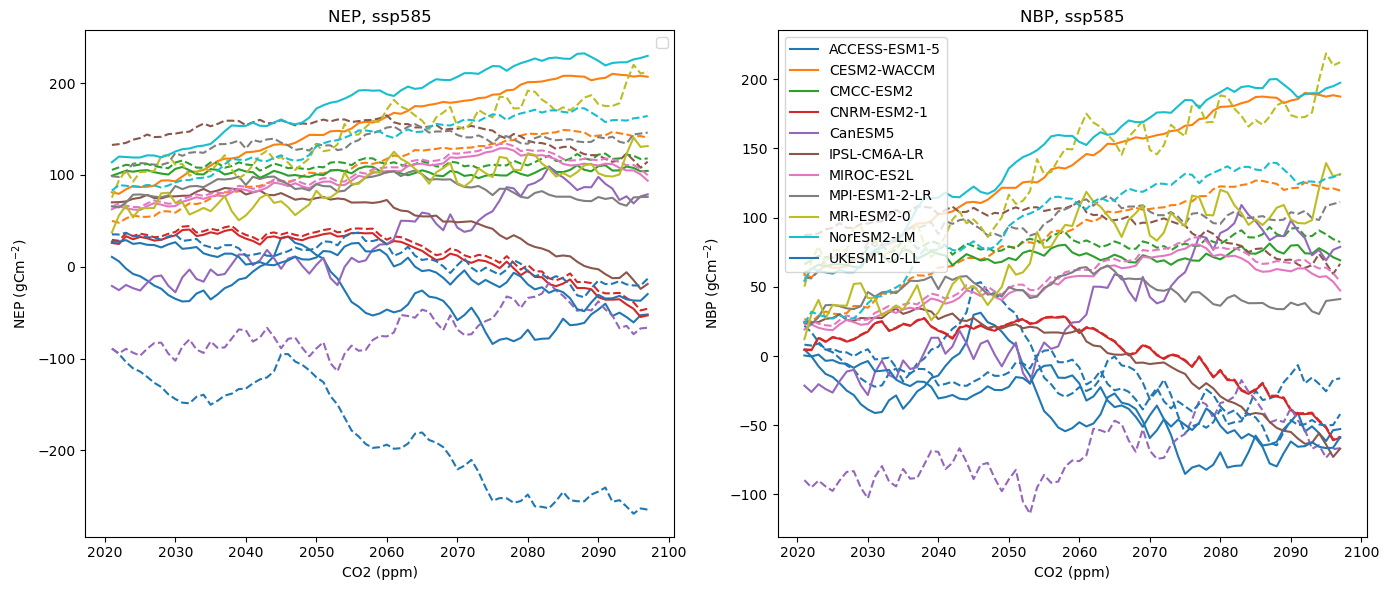

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

fig = plt.figure(figsize=(14, 6))

# Plot annual mean zonal values in the Amazon basin of each model
ax0 = fig.add_subplot(121)
for m, mm in enumerate(models):
    # Plot the first line
    line1, = ax0.plot(df_amz_ssp.index, df_amz_ssp[f'nep {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax0.plot(df_amz_ssp_net.index, df_amz_ssp_net[f'nep {mm}'].rolling(10, center=True).mean(), linestyle='--', color=line1.get_color())# Set labels and title

ax0.set_xlabel("CO2 (ppm)")
ax0.set_ylabel("NEP (gCm$^{-2}$)")
# ax0.set_ylim(-200, 400)

# Highlight a specific CO2 value with a vertical line
# ax0.axvline(df_amz_ssp.iloc[30].index, color="grey", alpha=0.7)

# Add legend and title
ax0.legend("") #
ax0.set_title("NEP, ssp585")

# Second plot for NBP
ax1 = fig.add_subplot(122)
for m, mm in enumerate(models):
    # Plot the first line
    line2, = ax1.plot(df_amz_ssp.index, df_amz_ssp[f'nbp {mm}'].rolling(10, center=True).mean(), label=mm)
    # Plot the second line with the same color but dashed
    ax1.plot(df_amz_ssp_net.index, df_amz_ssp_net[f'nbp {mm}'].rolling(10, center=True).mean(), linestyle='--', color=line2.get_color(), label = "_nolegend_")# Set labels and title
        
# Set labels and title
ax1.set_xlabel("CO2 (ppm)")
ax1.set_ylabel("NBP (gCm$^{-2}$)")
# ax1.set_ylim(-200, 400)

# Highlight a specific CO2 value with a vertical line
# ax1.axvline(df_amz_ssp.iloc[30].index, color="grey", alpha=0.7)

# Add legend and title
ax1.legend(models, loc = "upper left")
ax1.set_title("NBP, ssp585")

plt.tight_layout()
plt.show()
